#  Analyse the quality of the PSF for target

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : April 22th  2021
- version v1.0

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
from datetime import datetime,date

In [5]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [6]:
string_date

'2021-04-24'

In [7]:
from iminuit import Minuit
import iminuit

In [8]:
iminuit.__version__

'2.2.0'

In [9]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [10]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [11]:
from time import sleep

In [12]:
from astropy.time import Time
import astropy.units as u

# Function

In [13]:
def file_target(filename):
    m=re.findall('^Cor_holo4_003_.*_(.*)_[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*[.]fits$',filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []

# Logbook for file selection

In [14]:
filename_logbook='logbooks/auxtellogbook_2021_v1.2.csv'
filename_logbook_out='logbooks/auxtellogbook_2021_v1.3.csv'

In [15]:
df=pd.read_csv(filename_logbook,index_col=0)

In [16]:
pd.set_option('display.max_rows', None)

In [17]:
df

index                     date  \
0       0  2021-02-17T01:45:09.091   
1       1  2021-02-17T03:37:12.647   
2       2  2021-02-18T07:25:02.387   
3       3  2021-02-18T07:25:46.560   
4       4  2021-02-18T07:26:07.146   
5       5  2021-02-18T07:26:18.957   
6       6  2021-02-18T07:26:43.049   
7       7  2021-02-18T07:26:51.615   
8       8  2021-02-18T07:27:00.190   
9       9  2021-02-18T07:27:53.863   
10     10  2021-02-18T07:29:41.903   
11     11  2021-02-19T05:53:27.926   
12     12  2021-02-19T05:55:59.153   
13     13  2021-02-19T05:56:26.421   
14     14  2021-02-19T05:59:48.510   
15     15  2021-02-19T06:02:10.932   
16     16  2021-02-19T06:03:07.565   
17     17  2021-02-19T06:03:51.105   
18     18  2021-02-19T06:04:27.300   
19     19  2021-02-19T06:05:05.010   
20     20  2021-02-19T06:06:29.575   
21     21  2021-02-19T06:06:53.561   
22     22  2021-02-19T06:07:09.034   
23     23  2021-02-19T06:07:49.989   
24     24  2021-02-19T06:09:04.533   
25     25  2021-02-19T06:09:36.863   
26     26  2021-02-19T06:11:51.450   
27     27  2021-02-19T06:12:39.359   
28     28  2021-02-19T06:13:21.360   
29     29  2021-02-19T06:13:36.394   
30     30  2021-02-19T06:13:43.043   
31     31  2021-02-19T06:13:50.035   
32     32  2021-02-19T06:13:57.849   
33     33  2021-02-19T06:14:06.963   
34     34  2021-02-19T06:14:16.655   
35     35  2021-02-19T06:14:25.695   
36     36  2021-02-19T06:14:35.269   
37     37  2021-02-19T06:15:14.640   
38     38  2021-02-19T06:15:29.988   
39     39  2021-02-19T06:15:42.966   
40     40  2021-02-19T06:16:00.336   
41     41  2021-02-19T06:16:42.390   
42     42  2021-02-19T06:18:37.431   
43     43  2021-02-19T06:25:48.342   
44     44  2021-02-19T06:26:07.604   
45     45  2021-02-19T06:26:35.551   
46     46  2021-02-19T06:28:33.570   
47     47  2021-02-19T06:29:01.054   
48     48  2021-03-12T01:01:30.478   
49     49  2021-03-12T01:02:00.570   
50     50  2021-03-12T01:02:28.770   
51     51  2021-03-12T01:23:46.224   
52     52  2021-03-12T01:24:21.169   
53     53  2021-03-12T01:24:42.413   
54     54  2021-03-12T02:45:25.087   
55     55  2021-03-12T02:47:31.346   
56     56  2021-03-12T02:48:00.283   
57     57  2021-03-12T02:48:29.927   
58     58  2021-03-12T02:48:58.831   
59     59  2021-03-12T02:49:27.942   
60     60  2021-03-12T02:49:57.673   
61     61  2021-03-12T02:50:27.091   
62     62  2021-03-12T02:50:56.136   
63     63  2021-03-12T02:51:25.196   
64     64  2021-03-12T02:51:54.248   
65     65  2021-03-12T02:52:23.352   
66     66  2021-03-12T02:52:52.463   
67     67  2021-03-12T02:53:21.563   
68     68  2021-03-12T02:53:51.050   
69     69  2021-03-12T02:54:20.571   
70     70  2021-03-12T02:54:49.518   
71     71  2021-03-12T02:55:18.628   
72     72  2021-03-12T02:55:47.723   
73     73  2021-03-12T02:56:17.274   
74     74  2021-03-12T02:56:46.922   
75     75  2021-03-12T02:57:15.859   

                                                 path  \
0   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
1   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
2   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
3   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
4   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
5   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
6   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
7   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
8   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
9   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
10  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
11  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
12  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
13  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
14  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
15  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
16  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
17  /sps/lsst/groups/auxtel/data/2021/holo/FlipClea

# Selection of input file


- the target coordinates 'Obj-posXpix','Obj-posYpix' must exists.

### Drop NA

In [18]:
df.dropna(how='any', subset=['Obj-posXpix','Obj-posYpix'],inplace=True)

### Drop bad quality

In [19]:
#i = df[(df.run != 1) | (df.quality != 1)].index

In [20]:
#i

In [21]:
#df.drop(i,inplace=True)

## View

In [22]:
df

index                     date  \
2       2  2021-02-18T07:25:02.387   
3       3  2021-02-18T07:25:46.560   
4       4  2021-02-18T07:26:07.146   
5       5  2021-02-18T07:26:18.957   
6       6  2021-02-18T07:26:43.049   
7       7  2021-02-18T07:26:51.615   
8       8  2021-02-18T07:27:00.190   
9       9  2021-02-18T07:27:53.863   
10     10  2021-02-18T07:29:41.903   
11     11  2021-02-19T05:53:27.926   
12     12  2021-02-19T05:55:59.153   
13     13  2021-02-19T05:56:26.421   
14     14  2021-02-19T05:59:48.510   
15     15  2021-02-19T06:02:10.932   
16     16  2021-02-19T06:03:07.565   
17     17  2021-02-19T06:03:51.105   
18     18  2021-02-19T06:04:27.300   
19     19  2021-02-19T06:05:05.010   
20     20  2021-02-19T06:06:29.575   
21     21  2021-02-19T06:06:53.561   
22     22  2021-02-19T06:07:09.034   
23     23  2021-02-19T06:07:49.989   
24     24  2021-02-19T06:09:04.533   
25     25  2021-02-19T06:09:36.863   
26     26  2021-02-19T06:11:51.450   
27     27  2021-02-19T06:12:39.359   
28     28  2021-02-19T06:13:21.360   
29     29  2021-02-19T06:13:36.394   
30     30  2021-02-19T06:13:43.043   
31     31  2021-02-19T06:13:50.035   
32     32  2021-02-19T06:13:57.849   
33     33  2021-02-19T06:14:06.963   
34     34  2021-02-19T06:14:16.655   
35     35  2021-02-19T06:14:25.695   
36     36  2021-02-19T06:14:35.269   
37     37  2021-02-19T06:15:14.640   
38     38  2021-02-19T06:15:29.988   
39     39  2021-02-19T06:15:42.966   
40     40  2021-02-19T06:16:00.336   
41     41  2021-02-19T06:16:42.390   
42     42  2021-02-19T06:18:37.431   
44     44  2021-02-19T06:26:07.604   
45     45  2021-02-19T06:26:35.551   
46     46  2021-02-19T06:28:33.570   
47     47  2021-02-19T06:29:01.054   
48     48  2021-03-12T01:01:30.478   
49     49  2021-03-12T01:02:00.570   
51     51  2021-03-12T01:23:46.224   
52     52  2021-03-12T01:24:21.169   
53     53  2021-03-12T01:24:42.413   
55     55  2021-03-12T02:47:31.346   
56     56  2021-03-12T02:48:00.283   
57     57  2021-03-12T02:48:29.927   
58     58  2021-03-12T02:48:58.831   
59     59  2021-03-12T02:49:27.942   
60     60  2021-03-12T02:49:57.673   
61     61  2021-03-12T02:50:27.091   
62     62  2021-03-12T02:50:56.136   
63     63  2021-03-12T02:51:25.196   
64     64  2021-03-12T02:51:54.248   
65     65  2021-03-12T02:52:23.352   
66     66  2021-03-12T02:52:52.463   
67     67  2021-03-12T02:53:21.563   
68     68  2021-03-12T02:53:51.050   
69     69  2021-03-12T02:54:20.571   
70     70  2021-03-12T02:54:49.518   
71     71  2021-03-12T02:55:18.628   
72     72  2021-03-12T02:55:47.723   
73     73  2021-03-12T02:56:17.274   
74     74  2021-03-12T02:56:46.922   
75     75  2021-03-12T02:57:15.859   

                                                 path  \
2   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
3   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
4   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
5   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
6   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
7   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
8   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
9   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
10  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
11  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
12  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
13  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
14  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
15  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
16  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
17  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
18  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
19  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
20  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
21  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
22  /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
23  /sps/lsst

In [23]:
dir_images="/Users/dagoret/DATA/AuxTelData2021/holo/FlipCleans"
disperser_label = "holo4_003"
config = "config/auxtel_quicklook.ini"

In [24]:
idx=0
for filename_image in df["file"]:
    
    fullfilename=os.path.join(dir_images,filename_image)
    X=df.iloc[idx]["Obj-posXpix"]
    Y=df.iloc[idx]["Obj-posYpix"]
    guess = [X,Y]
    target = file_target(filename_image)[0]
    print(filename_image," ",target," ",guess)
    idx+=1

Cor_holo4_003_NGC4755_2021-02-17_350.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_351.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_352.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_353.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_354.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_355.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_356.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_357.fits   NGC4755   [700.0, 1700.0]
Cor_holo4_003_NGC4755_2021-02-17_358.fits   NGC4755   [500.0, 1800.0]
Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits   HD60753   [300.0, 2500.0]
Cor_holo4_003_RG610_HD60753_2021-02-18_557.fits   HD60753   [400.0, 2600.0]
Cor_holo4_003_RG610_HD60753_2021-02-18_558.fits   HD60753   [350.0, 2600.0]
Cor_holo4_003_RG610_HD60753_2021-02-18_559.fits   HD60753   [1800.0, 2500.0]
Cor_holo4_003_RG610_HD60753_2021-02-18_560.fits   HD60753   [400.

# Configuration of the running mode

In [25]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [26]:
FLAG_SHOW_SPECTRACTOR_IMAGES = False

In [27]:
if FLAG_SHOW_SPECTRACTOR_IMAGES:

    idx=0
    for filename_image in df["file"]:
        
        
        try:
    
            fullfilename=os.path.join(dir_images,filename_image)
            X=df.iloc[idx]["Obj-posXpix"]
            Y=df.iloc[idx]["Obj-posYpix"]
            guess = [int(X),int(Y)]
            target = file_target(filename_image)[0]
            print(idx,")  ",filename_image," ",target," ",guess)
    

            image=Image(file_name=fullfilename, target_label=target, disperser_label=disperser_label, config=config)
            image.plot_image(figsize=(6, 5),scale="log")
            
            x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
            
            print("x1,y1=",x1," , ",y1)
            
            
        except:
            msg=">>>FAILED : "+str(idx) + ") "+ filename_image + " " + target 
            print(msg)
            pass
            
        
        finally:
            idx+=1

0) Cor_holo4_003_NGC4755_2021-02-17_350.fits NGC4755


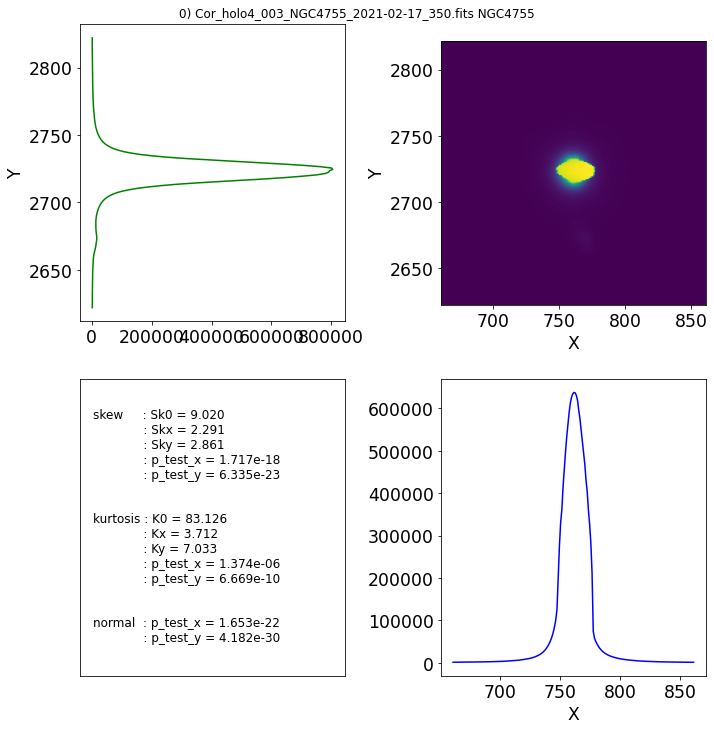

>>> FAILED : 0) Cor_holo4_003_NGC4755_2021-02-17_350.fits NGC4755
>>> FAILED : guess =  [750, 2700]
1) Cor_holo4_003_NGC4755_2021-02-17_351.fits NGC4755


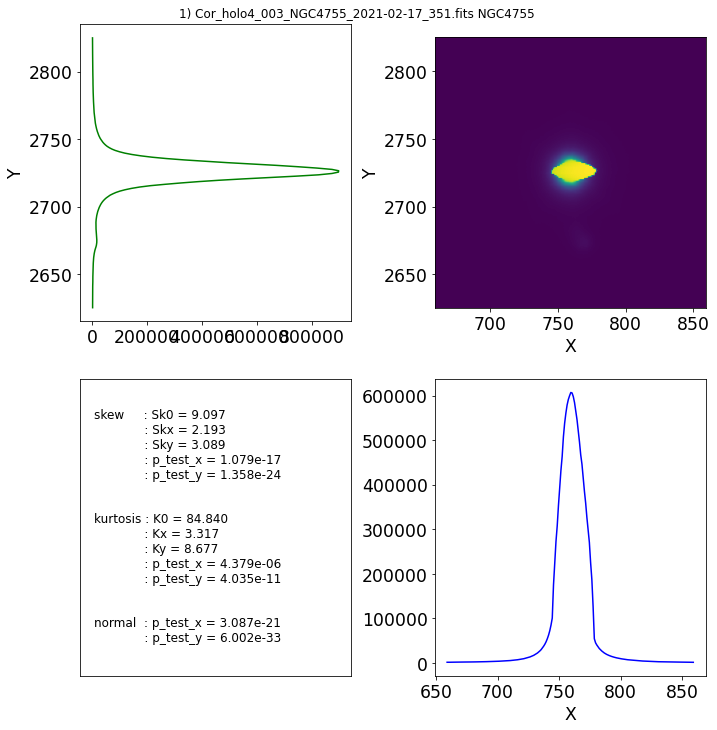

>>> FAILED : 1) Cor_holo4_003_NGC4755_2021-02-17_351.fits NGC4755
>>> FAILED : guess =  [750, 2700]
2) Cor_holo4_003_NGC4755_2021-02-17_352.fits NGC4755


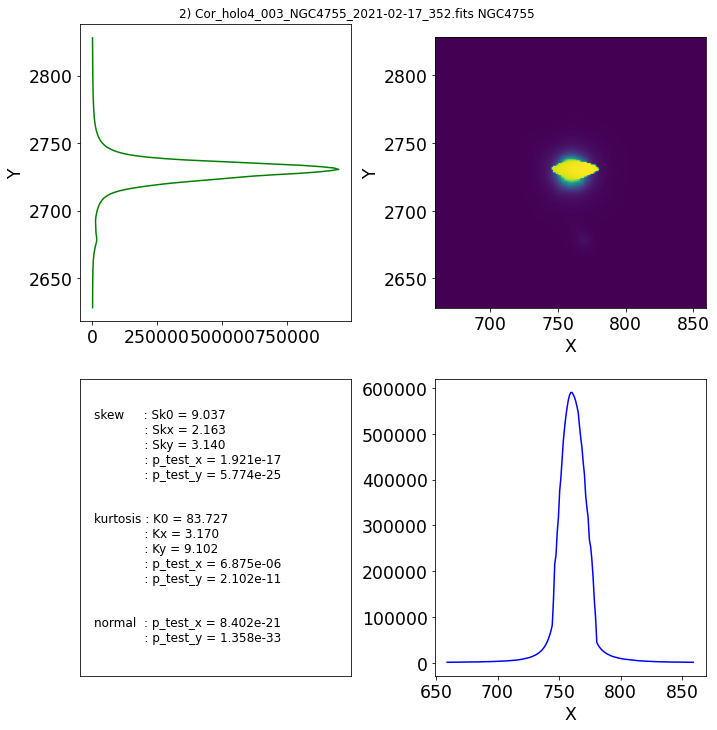

>>> FAILED : 2) Cor_holo4_003_NGC4755_2021-02-17_352.fits NGC4755
>>> FAILED : guess =  [750, 2700]
3) Cor_holo4_003_NGC4755_2021-02-17_353.fits NGC4755


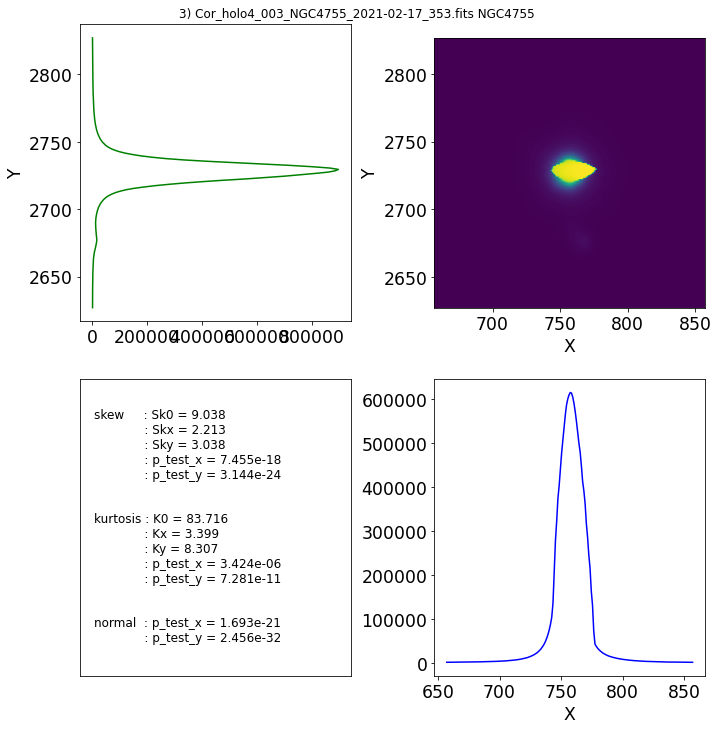

>>> FAILED : 3) Cor_holo4_003_NGC4755_2021-02-17_353.fits NGC4755
>>> FAILED : guess =  [750, 2700]
4) Cor_holo4_003_NGC4755_2021-02-17_354.fits NGC4755


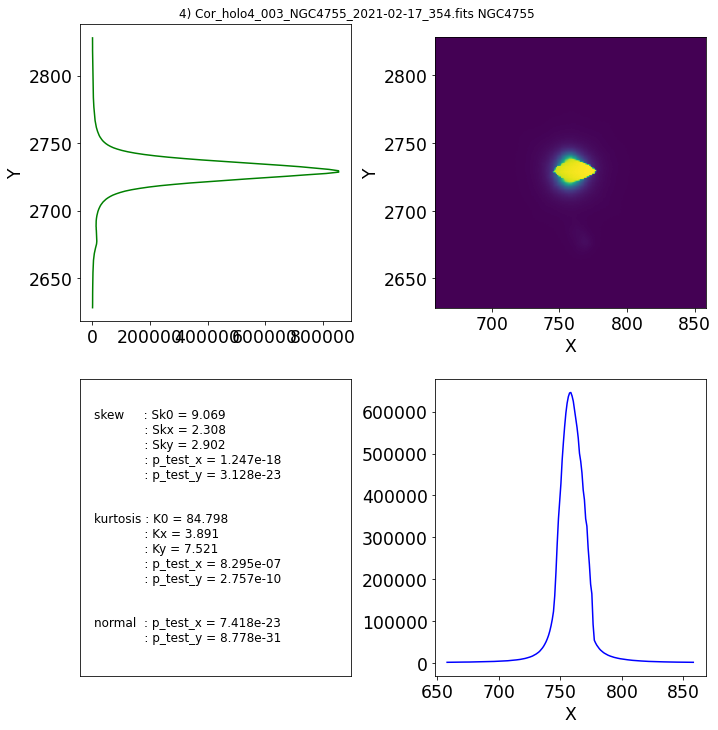

>>> FAILED : 4) Cor_holo4_003_NGC4755_2021-02-17_354.fits NGC4755
>>> FAILED : guess =  [750, 2700]
5) Cor_holo4_003_NGC4755_2021-02-17_355.fits NGC4755


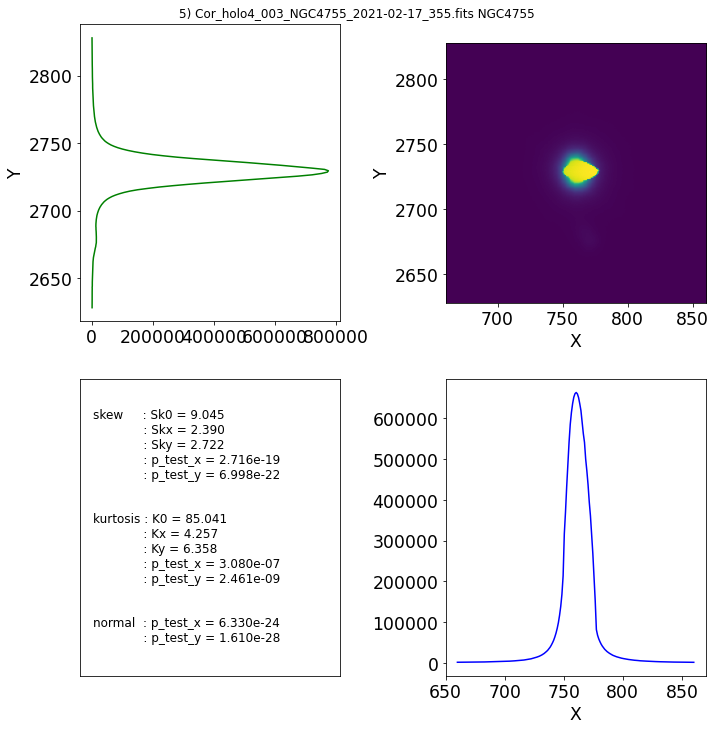

>>> FAILED : 5) Cor_holo4_003_NGC4755_2021-02-17_355.fits NGC4755
>>> FAILED : guess =  [750, 2700]
6) Cor_holo4_003_NGC4755_2021-02-17_356.fits NGC4755


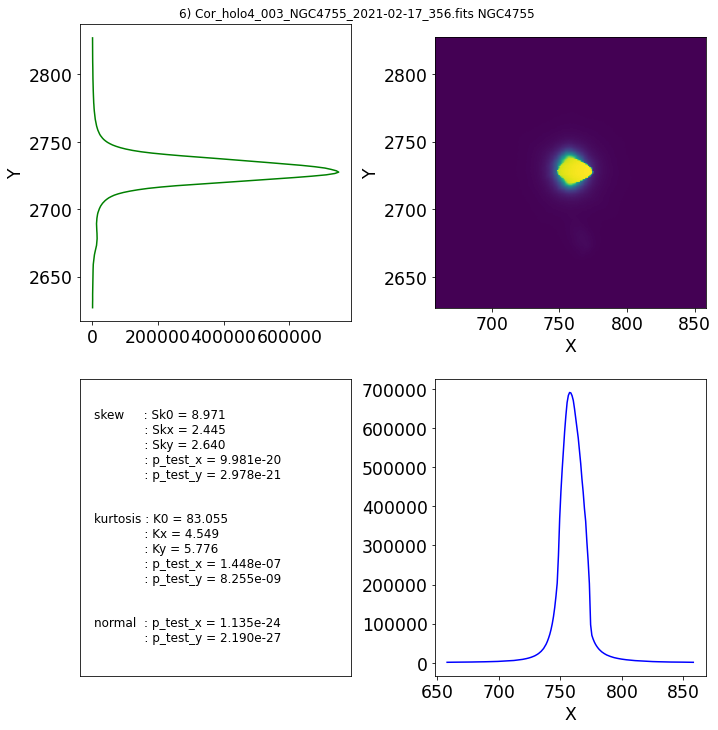

>>> FAILED : 6) Cor_holo4_003_NGC4755_2021-02-17_356.fits NGC4755
>>> FAILED : guess =  [750, 2700]
7) Cor_holo4_003_NGC4755_2021-02-17_357.fits NGC4755


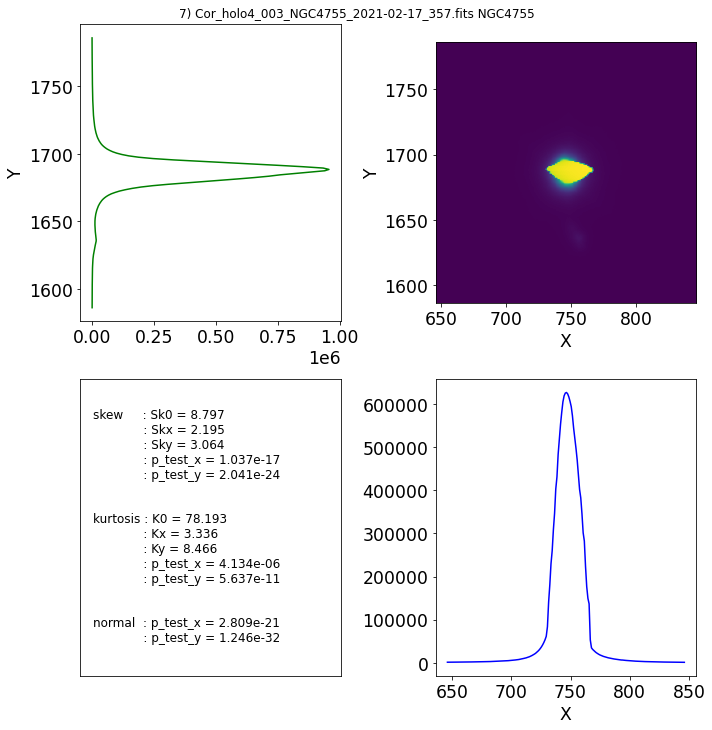

>>> FAILED : 7) Cor_holo4_003_NGC4755_2021-02-17_357.fits NGC4755
>>> FAILED : guess =  [700, 1700]
8) Cor_holo4_003_NGC4755_2021-02-17_358.fits NGC4755


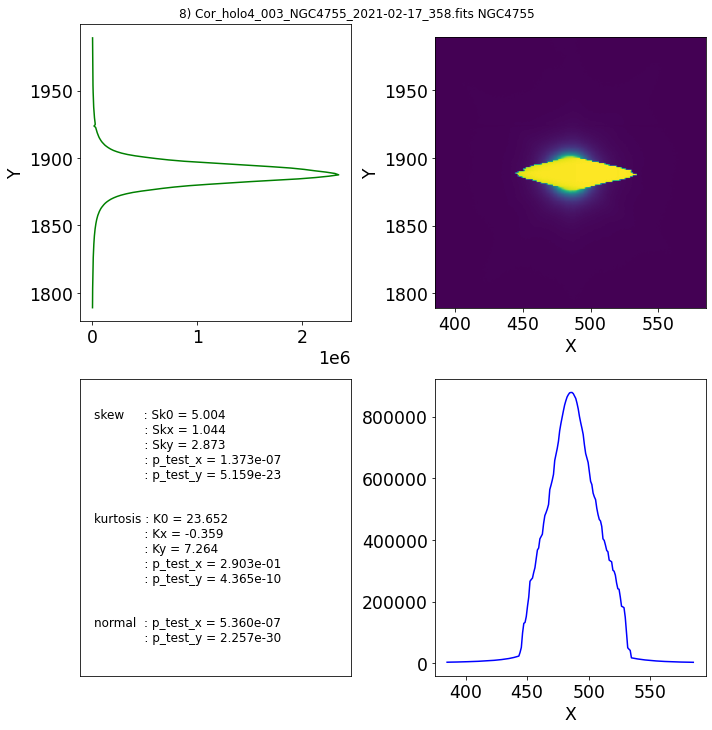

>>> FAILED : 8) Cor_holo4_003_NGC4755_2021-02-17_358.fits NGC4755
>>> FAILED : guess =  [500, 1800]
9) Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits HD60753


2021-04-24 20:51:28  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.358038467488372 but average of self.read_out_noise is 8.5.


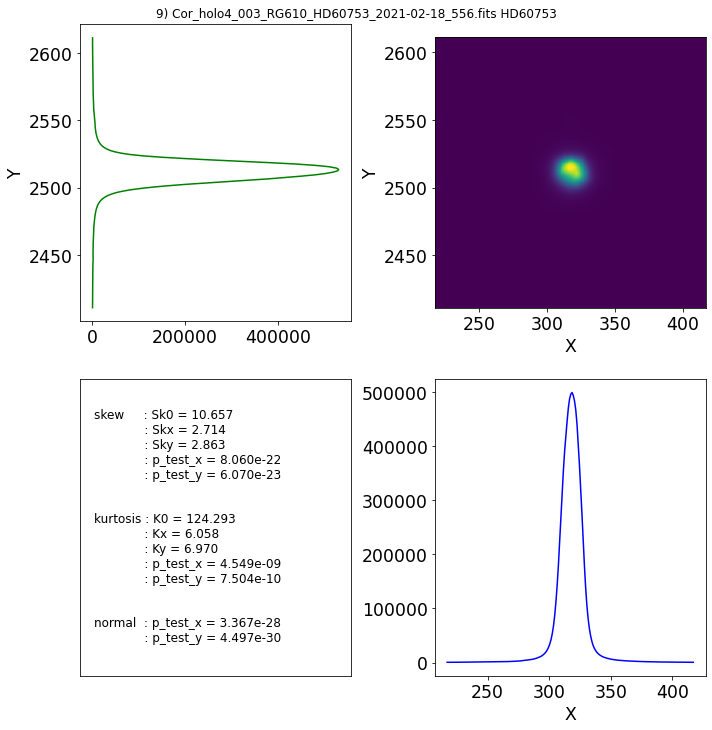

>>> FAILED : 9) Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits HD60753
>>> FAILED : guess =  [300, 2500]
10) Cor_holo4_003_RG610_HD60753_2021-02-18_557.fits HD60753


2021-04-24 20:51:48  Image      find_target_Moffat2D WARNING 
	X=71.66, Y=124.15 target position determination probably wrong: 18.6 pixels from profile detection (89.18, 130.23)
2021-04-24 20:51:49  Image      find_target_Moffat2D WARNING 
	X=54.72, Y=47.50 target position determination probably wrong: 12.7 pixels from profile detection (66.30, 52.67)


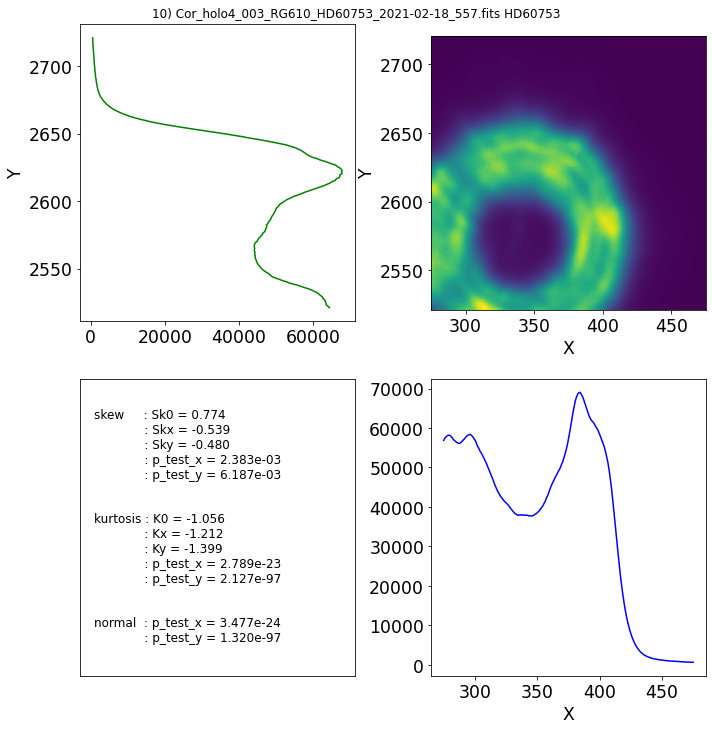

>>> FAILED : 10) Cor_holo4_003_RG610_HD60753_2021-02-18_557.fits HD60753
>>> FAILED : guess =  [400, 2600]
11) Cor_holo4_003_RG610_HD60753_2021-02-18_558.fits HD60753


2021-04-24 20:51:56  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: amplitude has a null Jacobian; parameter is fixed at its last known current value (-1.3294629752635956e-07).
2021-04-24 20:51:56  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: x_c has a null Jacobian; parameter is fixed at its last known current value (161.43341086586508).
2021-04-24 20:51:56  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: y_c has a null Jacobian; parameter is fixed at its last known current value (158.64869217796505).
2021-04-24 20:51:56  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: gamma has a null Jacobian; parameter is fixed at its last known current value (3.0).
2021-04-24 20:51:56  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: alpha has a null Jacobian; parameter is fixed at its last known current value (2.0).
2021-04-24 20:51:56  spectractor.fit.fitter gradient_descent     WARNING 
	Gradient descent terminated in 0 it

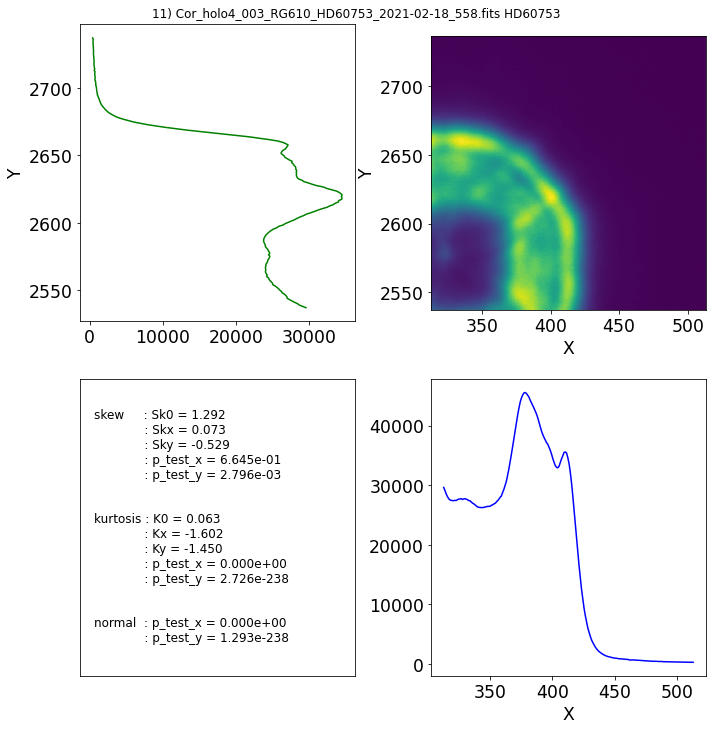

>>> FAILED : 11) Cor_holo4_003_RG610_HD60753_2021-02-18_558.fits HD60753
>>> FAILED : guess =  [350, 2600]
12) Cor_holo4_003_RG610_HD60753_2021-02-18_559.fits HD60753


2021-04-24 20:52:01  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.358019790912053 but average of self.read_out_noise is 8.5.


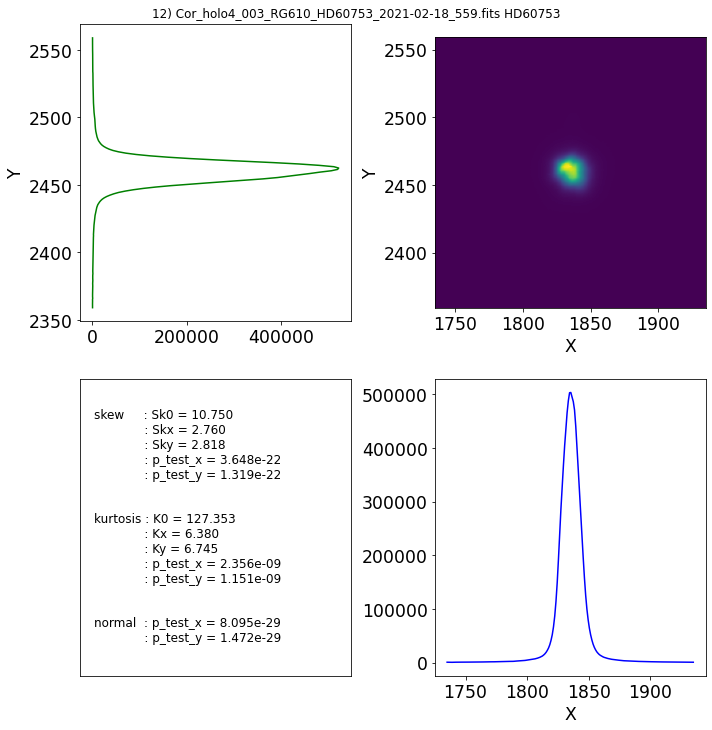

>>> FAILED : 12) Cor_holo4_003_RG610_HD60753_2021-02-18_559.fits HD60753
>>> FAILED : guess =  [1800, 2500]
13) Cor_holo4_003_RG610_HD60753_2021-02-18_560.fits HD60753


2021-04-24 20:52:12  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.354501572925415 but average of self.read_out_noise is 8.5.


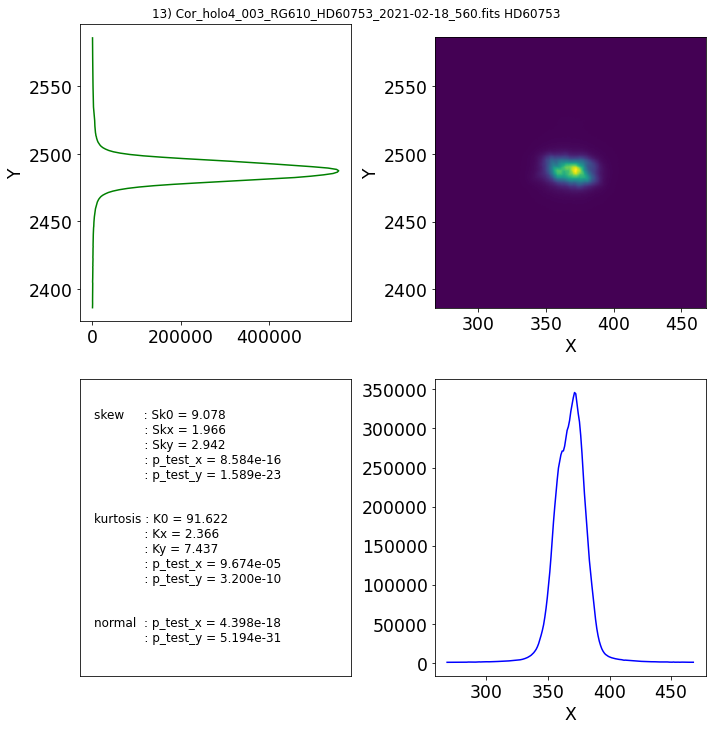

>>> FAILED : 13) Cor_holo4_003_RG610_HD60753_2021-02-18_560.fits HD60753
>>> FAILED : guess =  [400, 2500]
14) Cor_holo4_003_RG610_HD60753_2021-02-18_561.fits HD60753


2021-04-24 20:52:22  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.404876204890407 but average of self.read_out_noise is 8.5.


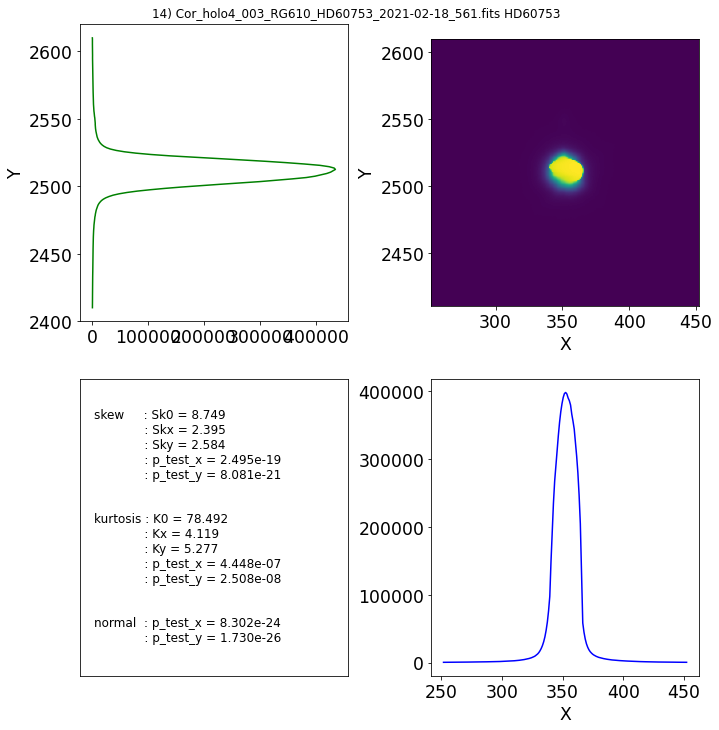

>>> FAILED : 14) Cor_holo4_003_RG610_HD60753_2021-02-18_561.fits HD60753
>>> FAILED : guess =  [400, 2500]
15) Cor_holo4_003_RG610_HD60753_2021-02-18_562.fits HD60753


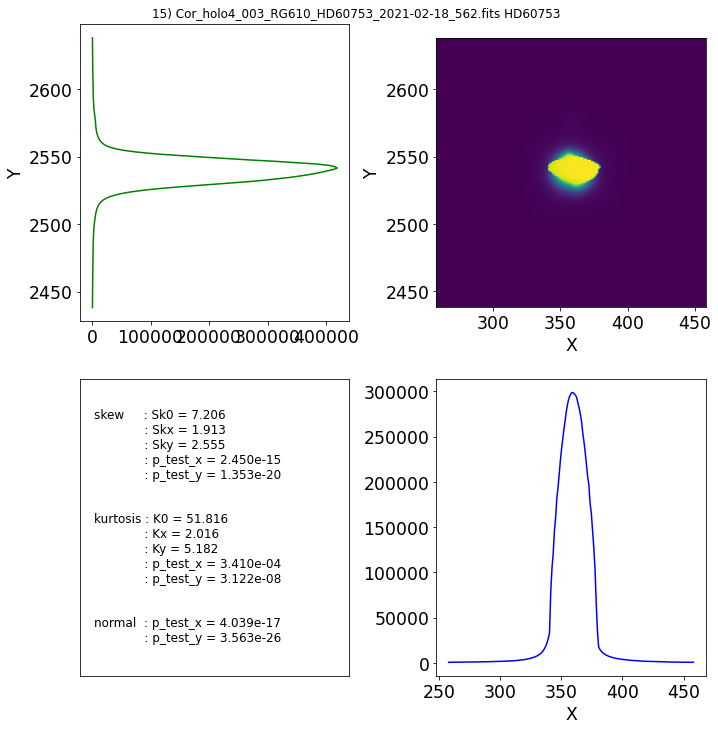

>>> FAILED : 15) Cor_holo4_003_RG610_HD60753_2021-02-18_562.fits HD60753
>>> FAILED : guess =  [400, 2500]
16) Cor_holo4_003_RG610_HD60753_2021-02-18_563.fits HD60753


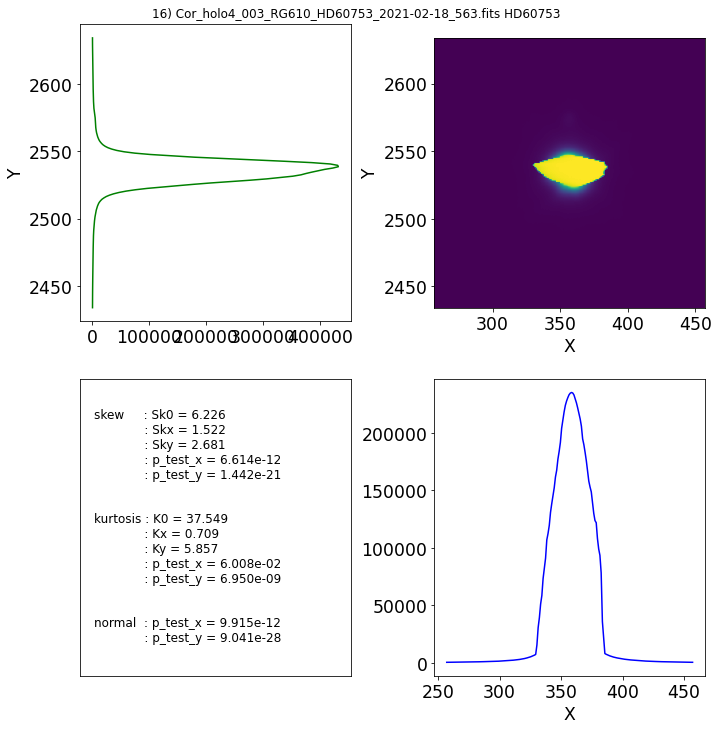

>>> FAILED : 16) Cor_holo4_003_RG610_HD60753_2021-02-18_563.fits HD60753
>>> FAILED : guess =  [400, 2500]
17) Cor_holo4_003_RG610_HD60753_2021-02-18_564.fits HD60753


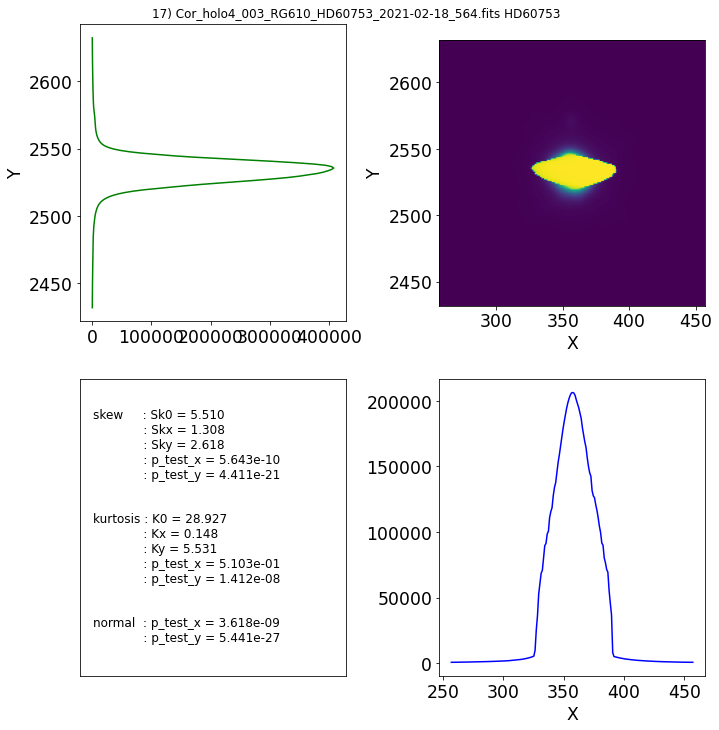

>>> FAILED : 17) Cor_holo4_003_RG610_HD60753_2021-02-18_564.fits HD60753
>>> FAILED : guess =  [400, 2500]
18) Cor_holo4_003_empty_HD60753_2021-02-18_566.fits HD60753


2021-04-24 20:53:19  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.382535473682855 but average of self.read_out_noise is 8.5.


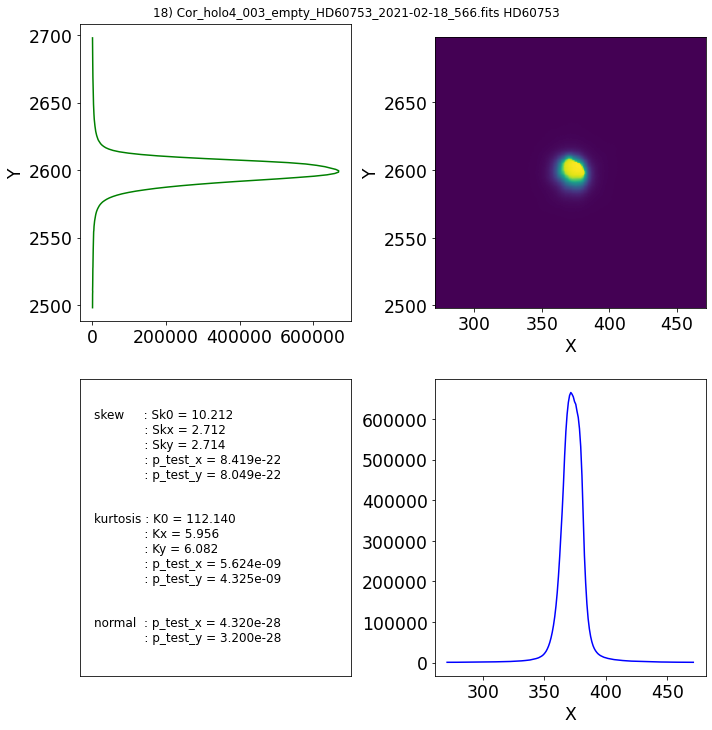

>>> FAILED : 18) Cor_holo4_003_empty_HD60753_2021-02-18_566.fits HD60753
>>> FAILED : guess =  [400, 2600]
19) Cor_holo4_003_empty_HD60753_2021-02-18_567.fits HD60753


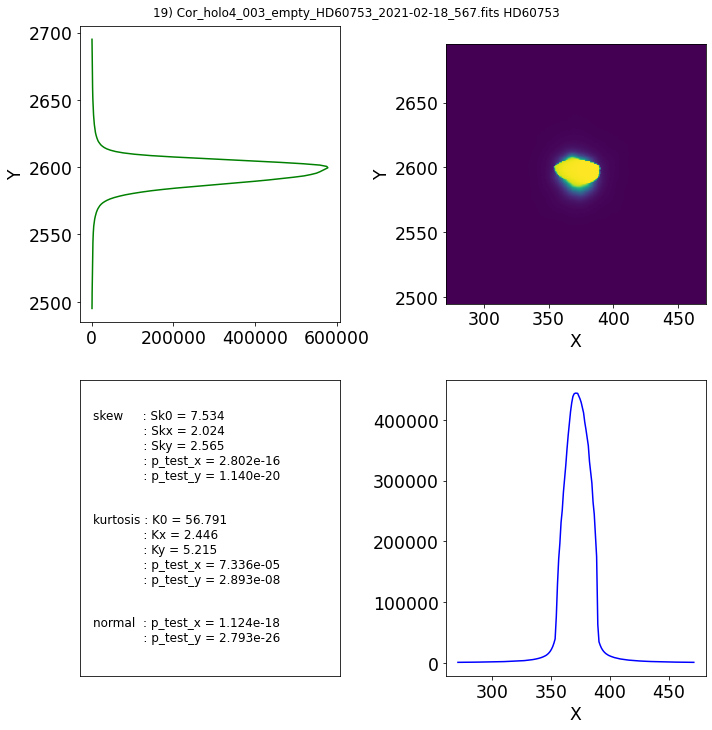

>>> FAILED : 19) Cor_holo4_003_empty_HD60753_2021-02-18_567.fits HD60753
>>> FAILED : guess =  [400, 2600]
20) Cor_holo4_003_empty_HD60753_2021-02-18_568.fits HD60753


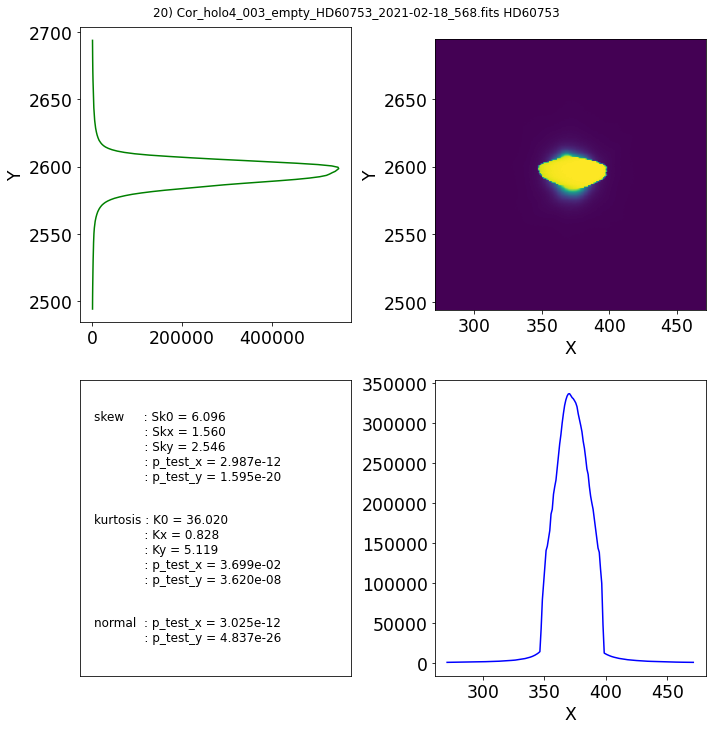

>>> FAILED : 20) Cor_holo4_003_empty_HD60753_2021-02-18_568.fits HD60753
>>> FAILED : guess =  [400, 2600]
21) Cor_holo4_003_empty_HD60753_2021-02-18_569.fits HD60753


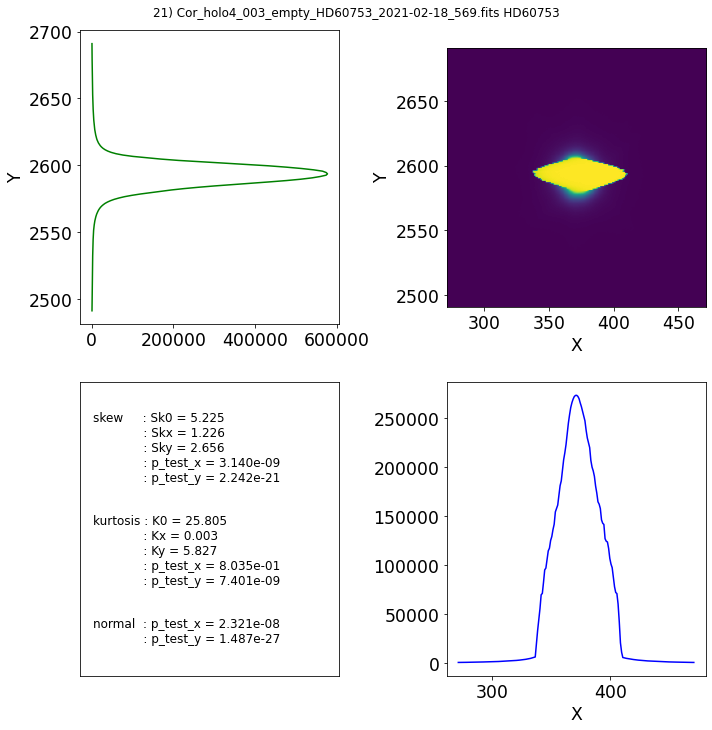

>>> FAILED : 21) Cor_holo4_003_empty_HD60753_2021-02-18_569.fits HD60753
>>> FAILED : guess =  [400, 2600]
22) Cor_holo4_003_empty_HD60753_2021-02-18_570.fits HD60753


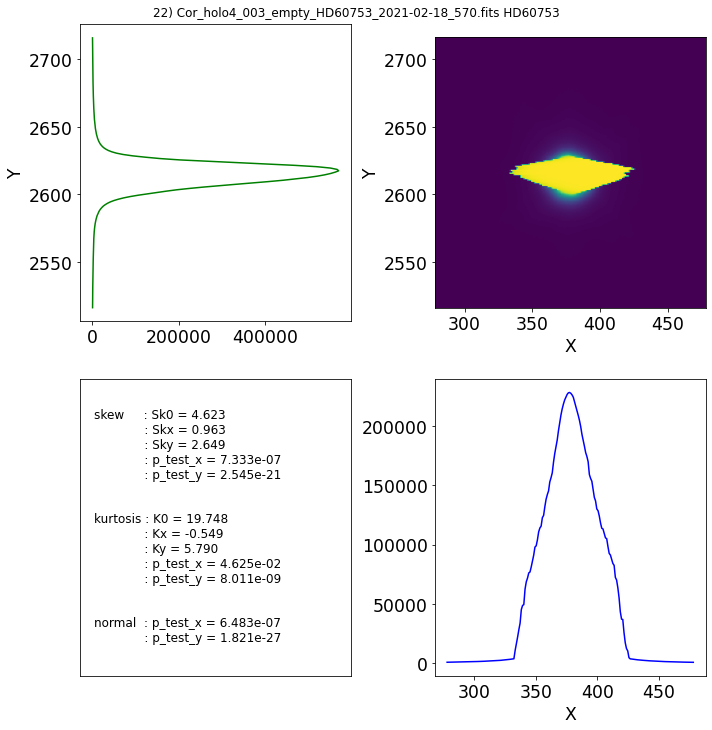

>>> FAILED : 22) Cor_holo4_003_empty_HD60753_2021-02-18_570.fits HD60753
>>> FAILED : guess =  [400, 2600]
23) Cor_holo4_003_empty_HD60753_2021-02-18_571.fits HD60753


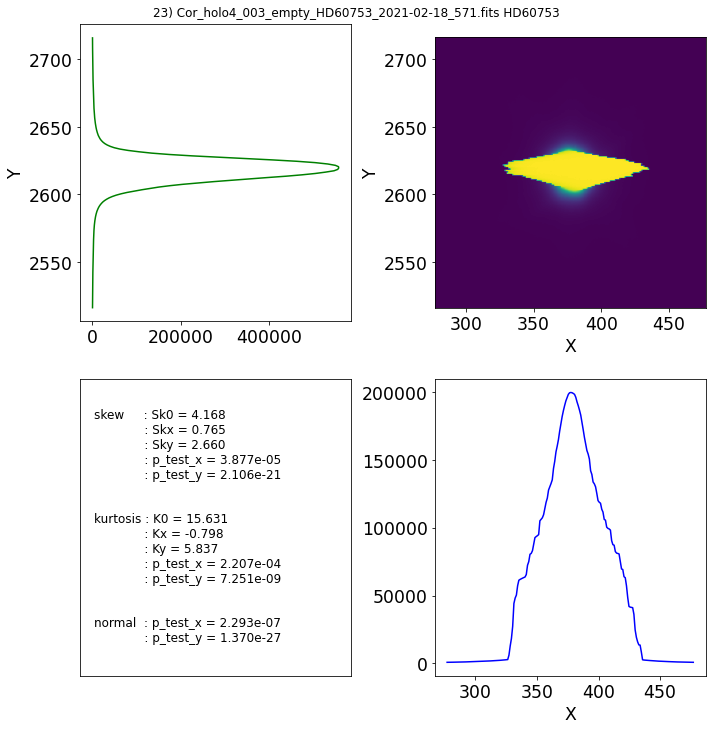

>>> FAILED : 23) Cor_holo4_003_empty_HD60753_2021-02-18_571.fits HD60753
>>> FAILED : guess =  [400, 2600]
24) Cor_holo4_003_empty_HD60753_2021-02-18_572.fits HD60753


2021-04-24 20:54:34  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.385541622870022 but average of self.read_out_noise is 8.5.


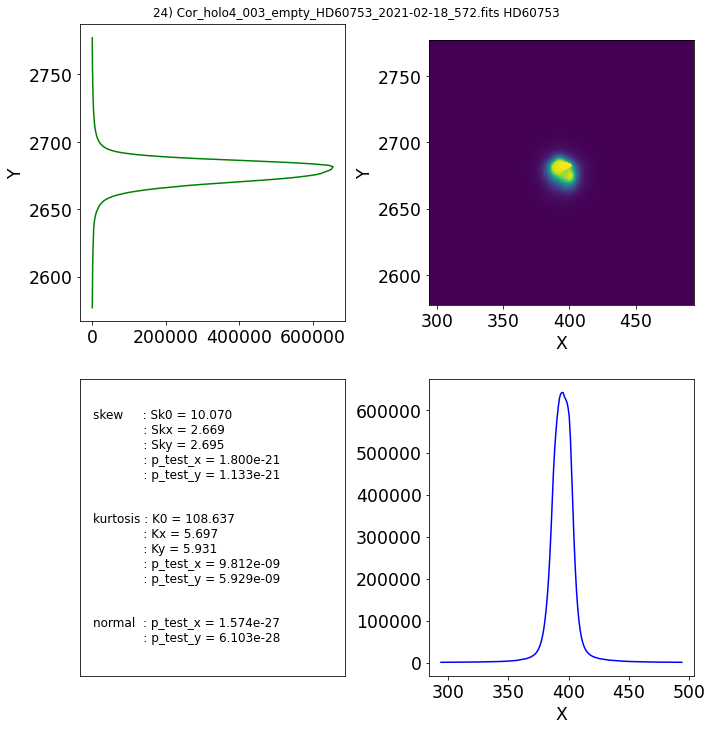

>>> FAILED : 24) Cor_holo4_003_empty_HD60753_2021-02-18_572.fits HD60753
>>> FAILED : guess =  [400, 2600]
25) Cor_holo4_003_empty_HD60753_2021-02-18_573.fits HD60753


2021-04-24 20:54:43  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.328332203183342 but average of self.read_out_noise is 8.5.


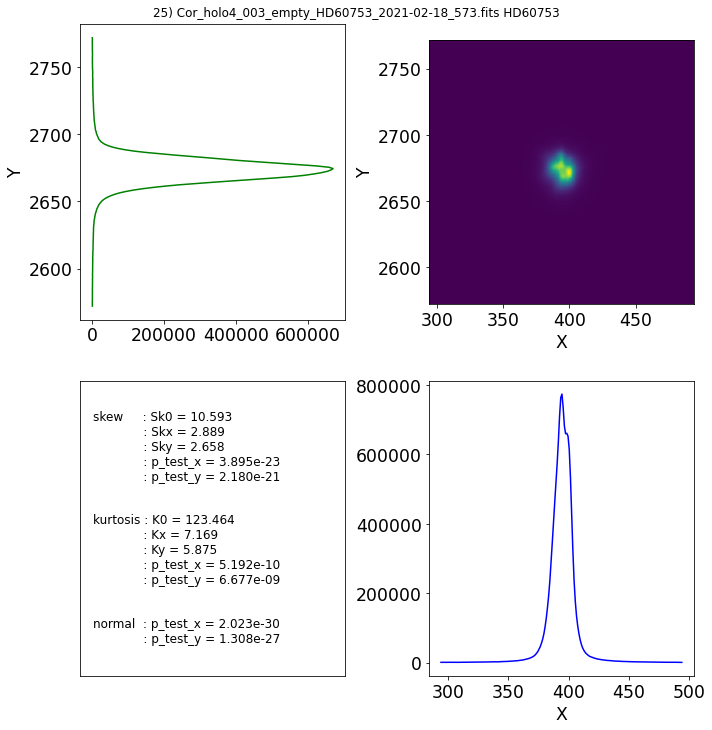

>>> FAILED : 25) Cor_holo4_003_empty_HD60753_2021-02-18_573.fits HD60753
>>> FAILED : guess =  [400, 2600]
26) Cor_holo4_003_empty_HD60753_2021-02-18_574.fits HD60753


2021-04-24 20:54:54  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.314410398246853 but average of self.read_out_noise is 8.5.


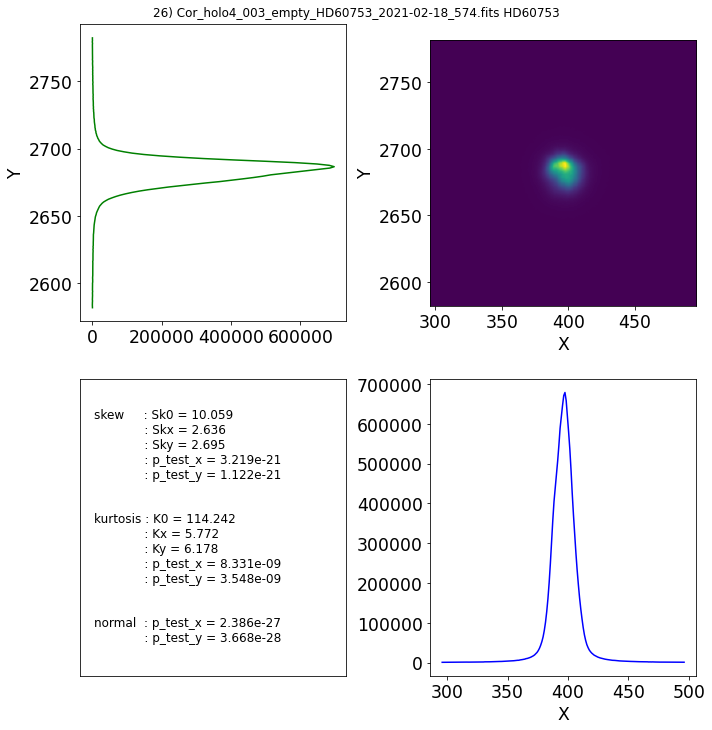

>>> FAILED : 26) Cor_holo4_003_empty_HD60753_2021-02-18_574.fits HD60753
>>> FAILED : guess =  [400, 2700]
27) Cor_holo4_003_empty_HD60753_2021-02-18_575.fits HD60753


2021-04-24 20:55:05  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.304168216053602 but average of self.read_out_noise is 8.5.


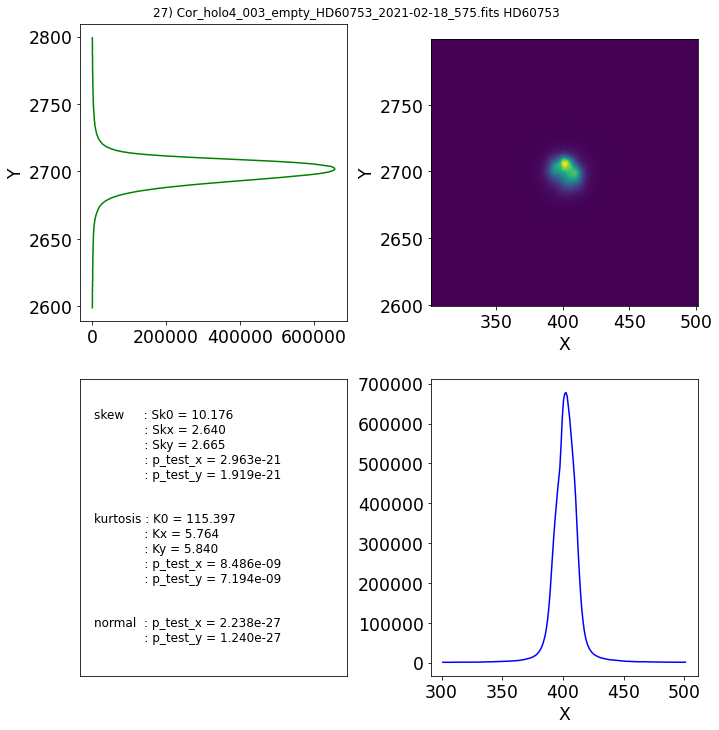

>>> FAILED : 27) Cor_holo4_003_empty_HD60753_2021-02-18_575.fits HD60753
>>> FAILED : guess =  [400, 2700]
28) Cor_holo4_003_empty_HD60753_2021-02-18_576.fits HD60753


2021-04-24 20:55:15  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.314063223847134 but average of self.read_out_noise is 8.5.


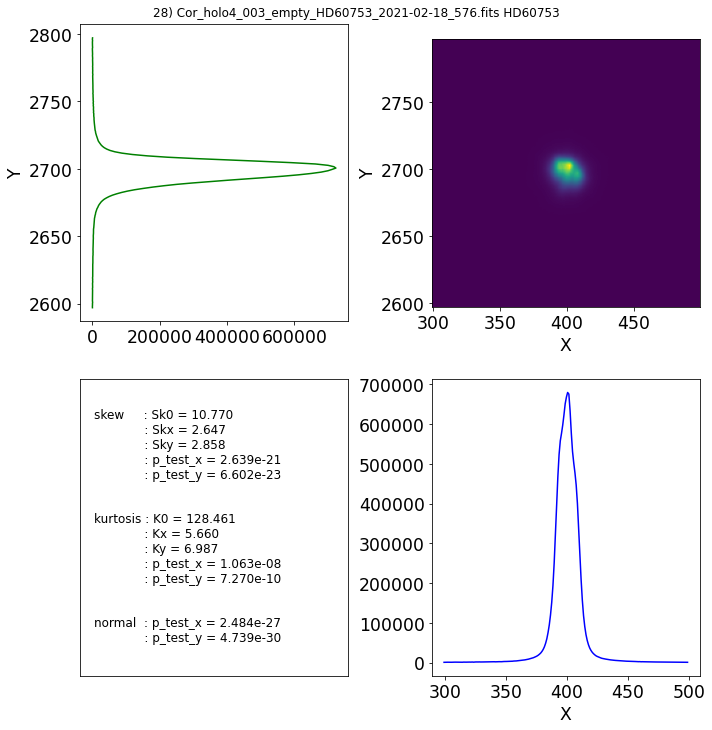

>>> FAILED : 28) Cor_holo4_003_empty_HD60753_2021-02-18_576.fits HD60753
>>> FAILED : guess =  [400, 2700]
29) Cor_holo4_003_empty_HD60753_2021-02-18_577.fits HD60753


2021-04-24 20:55:26  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.324224133709798 but average of self.read_out_noise is 8.5.


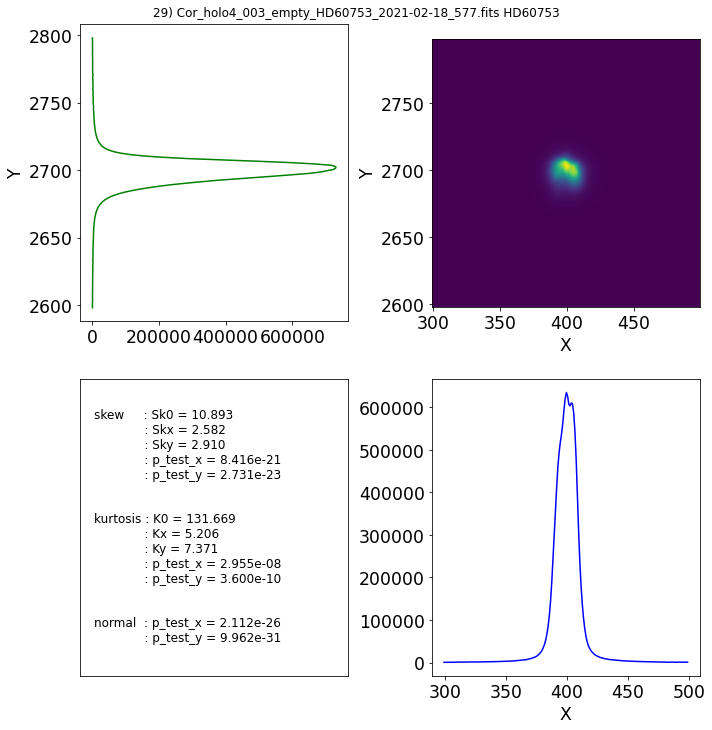

>>> FAILED : 29) Cor_holo4_003_empty_HD60753_2021-02-18_577.fits HD60753
>>> FAILED : guess =  [400, 2700]
30) Cor_holo4_003_empty_HD60753_2021-02-18_578.fits HD60753


2021-04-24 20:55:36  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.3127832333814 but average of self.read_out_noise is 8.5.


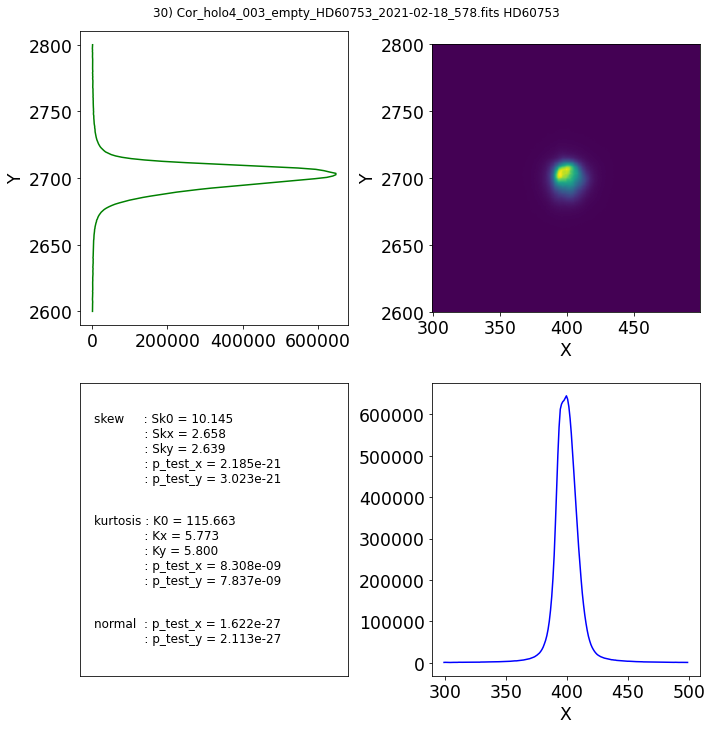

>>> FAILED : 30) Cor_holo4_003_empty_HD60753_2021-02-18_578.fits HD60753
>>> FAILED : guess =  [400, 2700]
31) Cor_holo4_003_empty_HD60753_2021-02-18_579.fits HD60753


2021-04-24 20:55:47  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.318389824134375 but average of self.read_out_noise is 8.5.


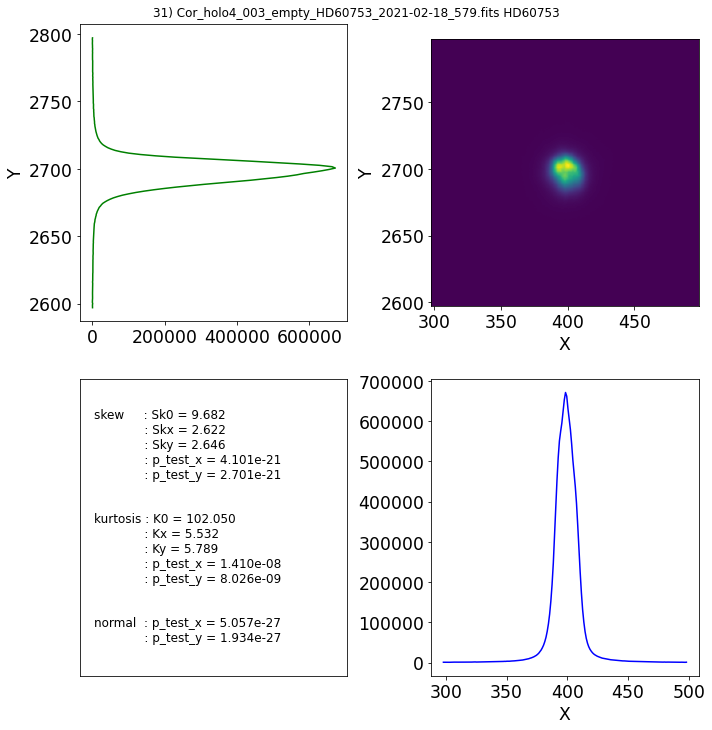

>>> FAILED : 31) Cor_holo4_003_empty_HD60753_2021-02-18_579.fits HD60753
>>> FAILED : guess =  [400, 2700]
32) Cor_holo4_003_empty_HD60753_2021-02-18_580.fits HD60753


2021-04-24 20:55:58  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.318192815971935 but average of self.read_out_noise is 8.5.


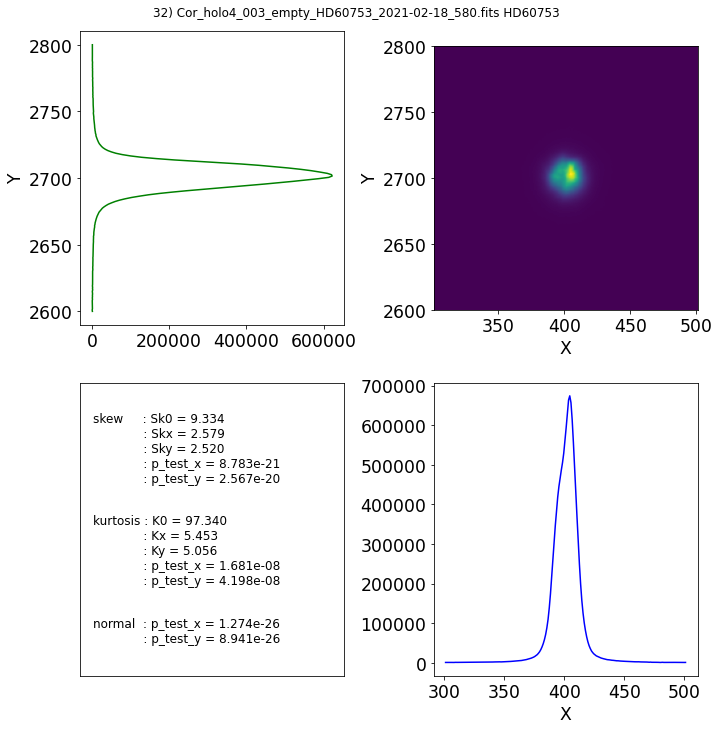

>>> FAILED : 32) Cor_holo4_003_empty_HD60753_2021-02-18_580.fits HD60753
>>> FAILED : guess =  [400, 2700]
33) Cor_holo4_003_empty_HD60753_2021-02-18_581.fits HD60753


2021-04-24 20:56:08  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.316524643496024 but average of self.read_out_noise is 8.5.


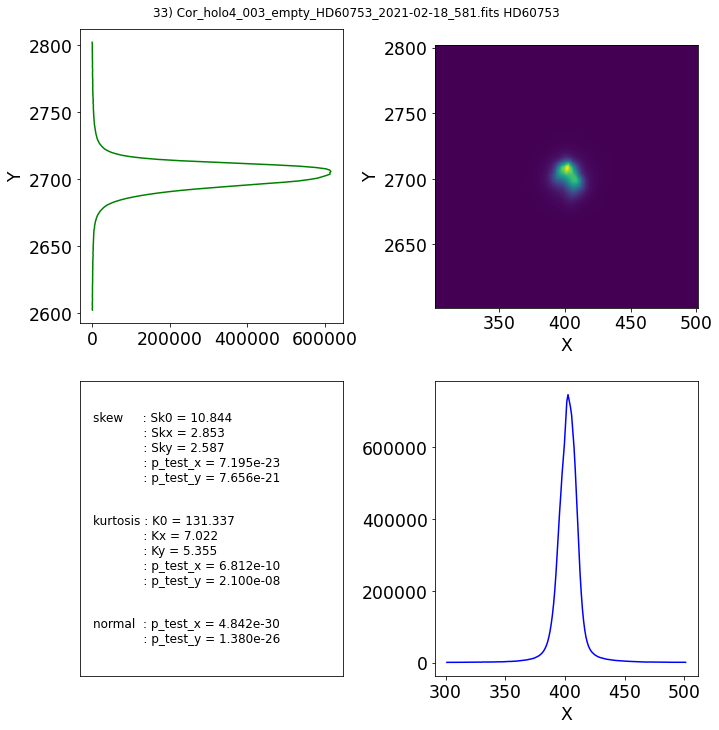

>>> FAILED : 33) Cor_holo4_003_empty_HD60753_2021-02-18_581.fits HD60753
>>> FAILED : guess =  [400, 2700]
34) Cor_holo4_003_empty_HD60753_2021-02-18_582.fits HD60753


2021-04-24 20:56:18  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.315372257450537 but average of self.read_out_noise is 8.5.


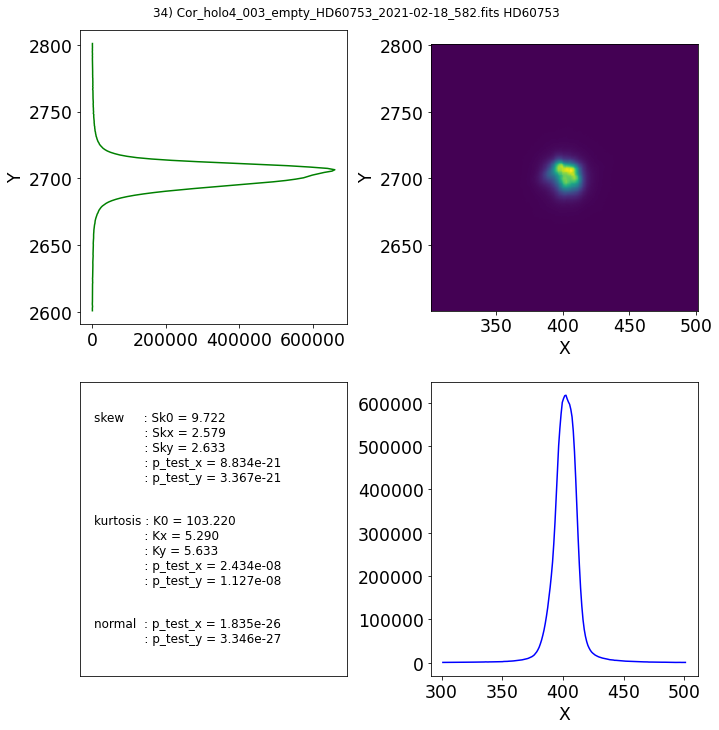

>>> FAILED : 34) Cor_holo4_003_empty_HD60753_2021-02-18_582.fits HD60753
>>> FAILED : guess =  [400, 2700]
35) Cor_holo4_003_empty_HD60753_2021-02-18_583.fits HD60753


2021-04-24 20:56:27  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.389962490381906 but average of self.read_out_noise is 8.5.


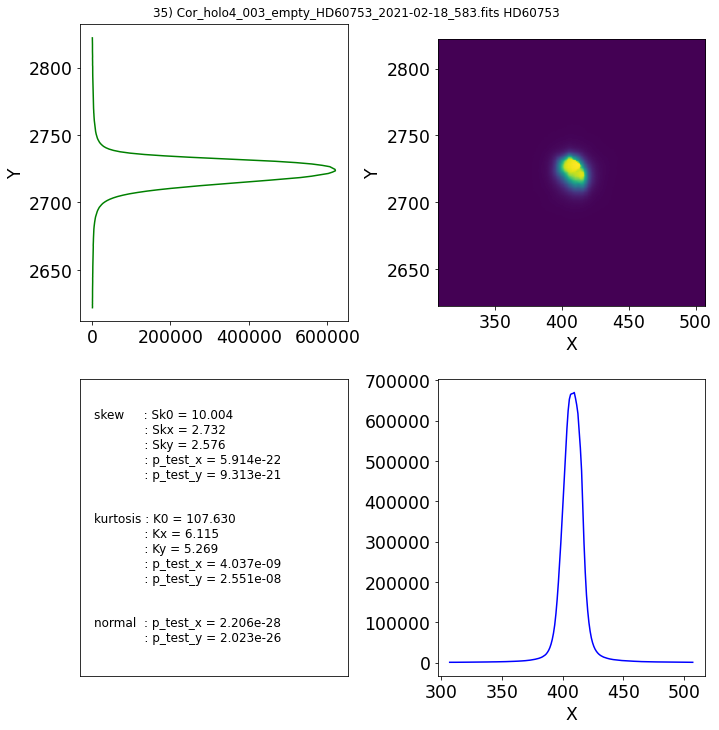

>>> FAILED : 35) Cor_holo4_003_empty_HD60753_2021-02-18_583.fits HD60753
>>> FAILED : guess =  [400, 2700]
36) Cor_holo4_003_empty_HD60753_2021-02-18_584.fits HD60753


2021-04-24 20:56:38  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.391464012880427 but average of self.read_out_noise is 8.5.


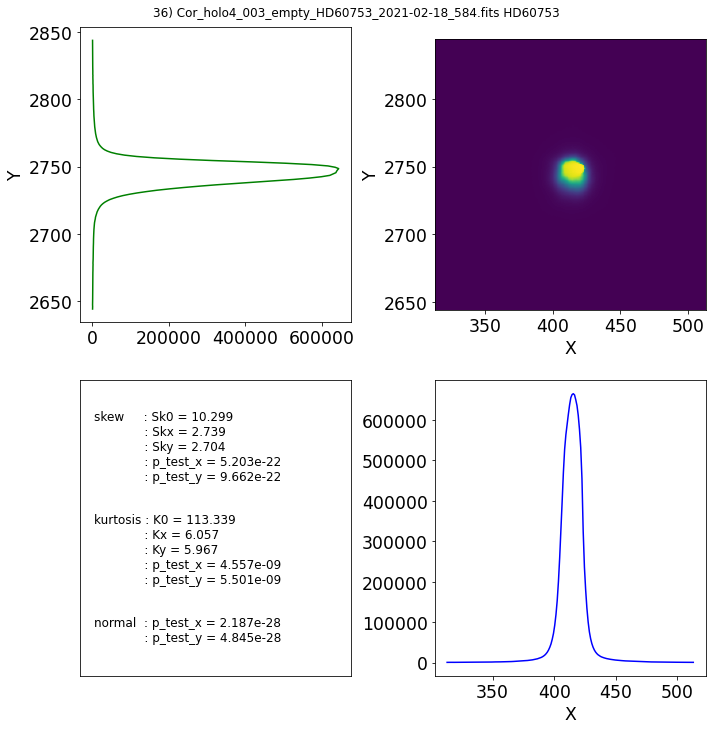

>>> FAILED : 36) Cor_holo4_003_empty_HD60753_2021-02-18_584.fits HD60753
>>> FAILED : guess =  [400, 2700]
37) Cor_holo4_003_empty_HD60753_2021-02-18_585.fits HD60753


2021-04-24 20:56:49  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.38898809440338 but average of self.read_out_noise is 8.5.


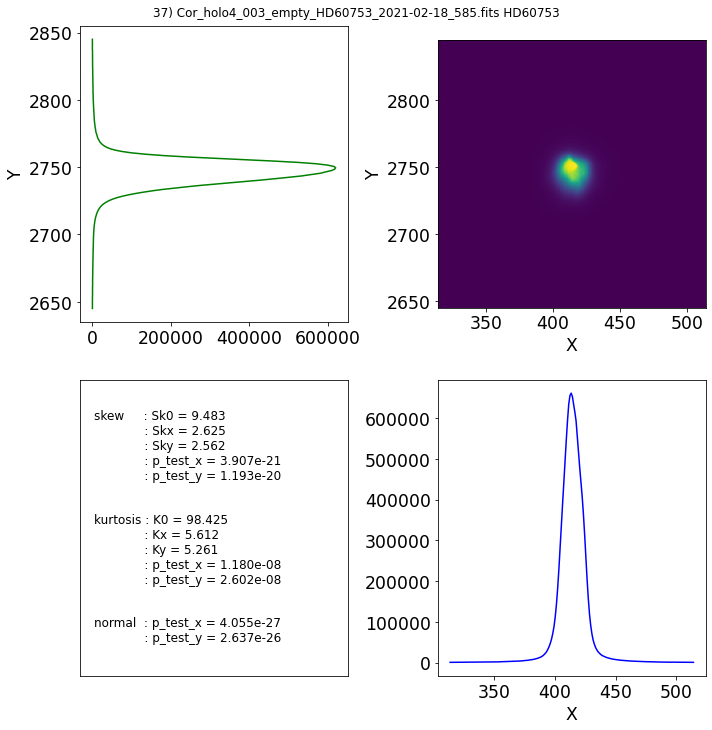

>>> FAILED : 37) Cor_holo4_003_empty_HD60753_2021-02-18_585.fits HD60753
>>> FAILED : guess =  [400, 2700]
38) Cor_holo4_003_empty_HD60753_2021-02-18_586.fits HD60753


2021-04-24 20:56:59  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.383683020316141 but average of self.read_out_noise is 8.5.


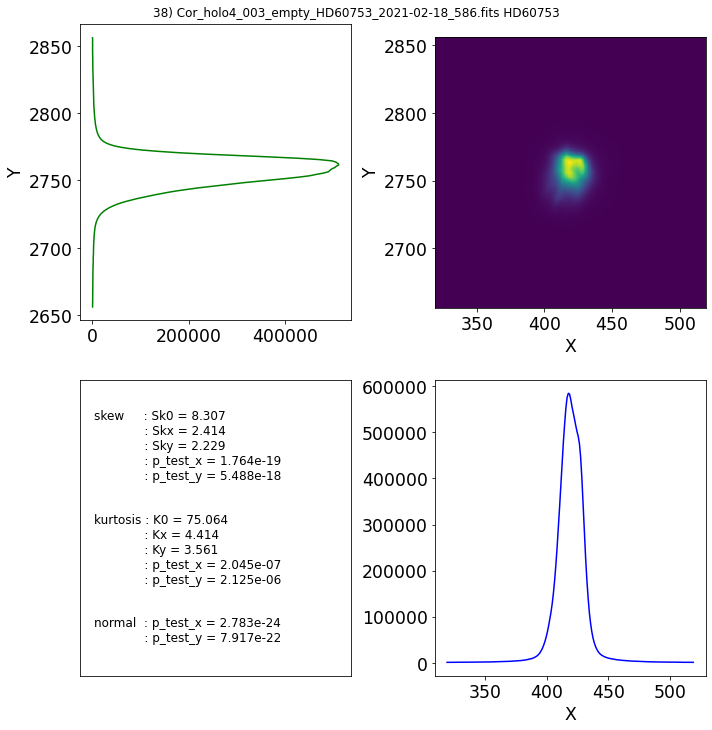

>>> FAILED : 38) Cor_holo4_003_empty_HD60753_2021-02-18_586.fits HD60753
>>> FAILED : guess =  [400, 2700]
39) Cor_holo4_003_empty_HD60753_2021-02-18_587.fits HD60753


2021-04-24 20:57:10  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.383877583596774 but average of self.read_out_noise is 8.5.


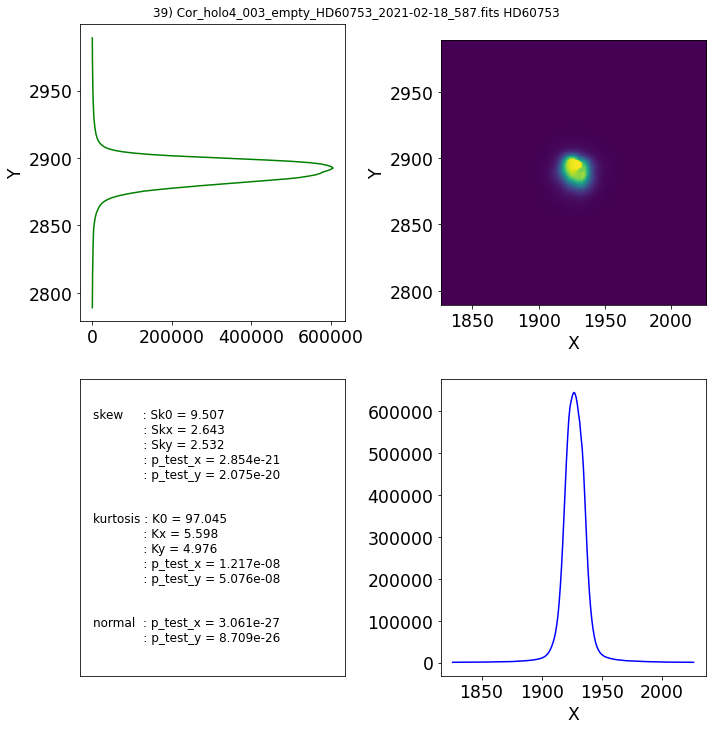

>>> FAILED : 39) Cor_holo4_003_empty_HD60753_2021-02-18_587.fits HD60753
>>> FAILED : guess =  [1900, 2900]
40) Cor_holo4_003_empty_HD60753_2021-02-18_588.fits HD60753


2021-04-24 20:57:26  spectractor.fit.fitter gradient_descent     WARNING 
	Step 2: amplitude has a null Jacobian; parameter is fixed at its last known current value (1008742.3216556417).
2021-04-24 20:57:26  spectractor.fit.fitter gradient_descent     WARNING 
	Step 2: x_c has a null Jacobian; parameter is fixed at its last known current value (-452257.4525882633).
2021-04-24 20:57:26  spectractor.fit.fitter gradient_descent     WARNING 
	Step 2: y_c has a null Jacobian; parameter is fixed at its last known current value (200.0).
2021-04-24 20:57:26  spectractor.fit.fitter gradient_descent     WARNING 
	Step 2: gamma has a null Jacobian; parameter is fixed at its last known current value (0.1).
2021-04-24 20:57:26  spectractor.fit.fitter gradient_descent     WARNING 
	Step 2: alpha has a null Jacobian; parameter is fixed at its last known current value (100.0).
2021-04-24 20:57:26  spectractor.fit.fitter gradient_descent     WARNING 
	Gradient descent terminated in 2 iterations because

>>> FAILED : 40) Cor_holo4_003_empty_HD60753_2021-02-18_588.fits HD60753
>>> FAILED : guess =  [1900, 2900]
41) Cor_holo4_003_RG610_HD114449_2021-02-18_591.fits HD114449


2021-04-24 20:57:36  Image      find_target_Moffat2D WARNING 
	X=140.83, Y=88.75 target position determination probably wrong: 71.9 pixels from profile detection (77.61, 122.99)
2021-04-24 20:57:38  Image      find_target_Moffat2D WARNING 
	X=55.01, Y=66.05 target position determination probably wrong: 21.3 pixels from profile detection (45.16, 84.89)


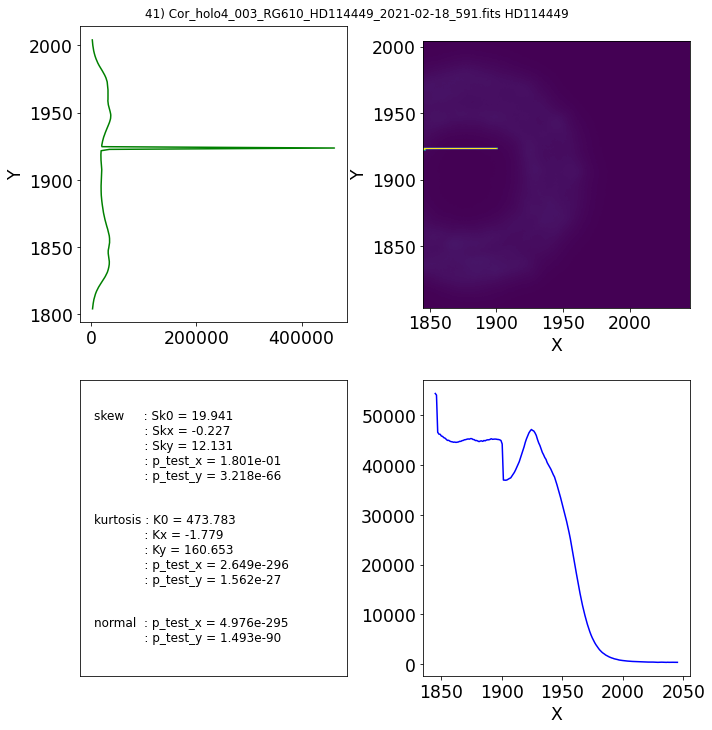

>>> FAILED : 41) Cor_holo4_003_RG610_HD114449_2021-02-18_591.fits HD114449
>>> FAILED : guess =  [1900, 1900]
42) Cor_holo4_003_RG610_HD114449_2021-02-18_592.fits HD114449


2021-04-24 20:57:52  Image      find_target_Moffat2D WARNING 
	X=101.80, Y=164.77 target position determination probably wrong: 48.6 pixels from profile detection (76.91, 122.99)
2021-04-24 20:57:53  Image      find_target_Moffat2D WARNING 
	X=37.32, Y=45.80 target position determination probably wrong: 37.6 pixels from profile detection (29.61, 9.00)


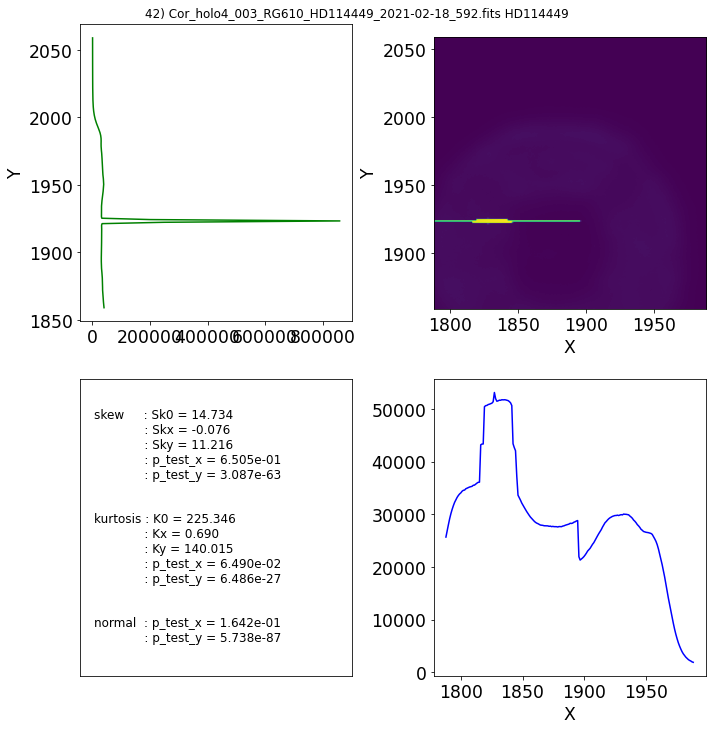

>>> FAILED : 42) Cor_holo4_003_RG610_HD114449_2021-02-18_592.fits HD114449
>>> FAILED : guess =  [1900, 1900]
43) Cor_holo4_003_RG610_HD114449_2021-02-18_593.fits HD114449


2021-04-24 20:58:06  Image      find_target_Moffat2D WARNING 
	X=130.93, Y=83.52 target position determination probably wrong: 66.2 pixels from profile detection (77.80, 122.99)
2021-04-24 20:58:08  Image      find_target_Moffat2D WARNING 
	X=63.08, Y=77.99 target position determination probably wrong: 20.4 pixels from profile detection (46.50, 89.97)


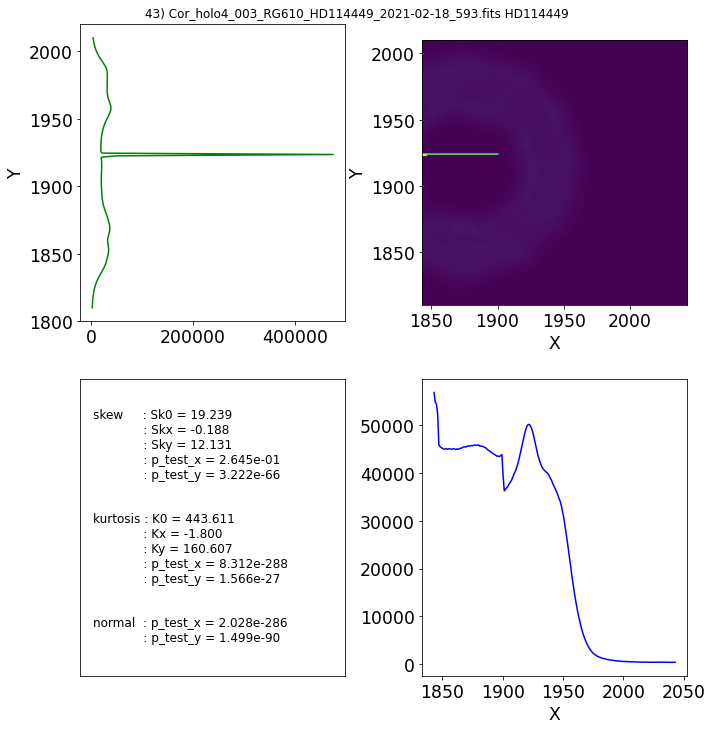

>>> FAILED : 43) Cor_holo4_003_RG610_HD114449_2021-02-18_593.fits HD114449
>>> FAILED : guess =  [1900, 1900]
44) Cor_holo4_003_RG610_HD114449_2021-02-18_594.fits HD114449


2021-04-24 20:58:20  Image      find_target_Moffat2D WARNING 
	X=96.29, Y=177.89 target position determination probably wrong: 57.9 pixels from profile detection (77.78, 122.99)
2021-04-24 20:58:21  Image      find_target_Moffat2D WARNING 
	X=53.22, Y=48.39 target position determination probably wrong: 18.0 pixels from profile detection (68.94, 39.67)


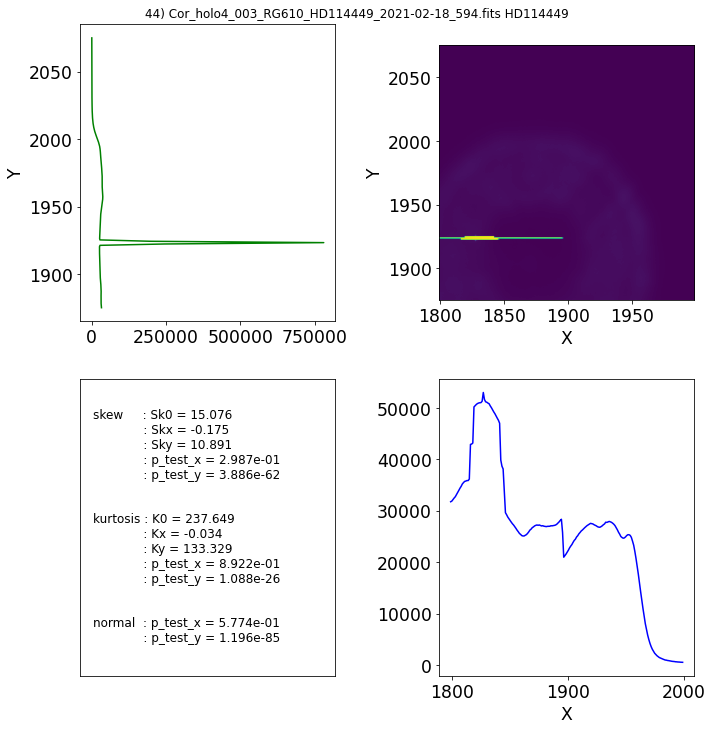

>>> FAILED : 44) Cor_holo4_003_RG610_HD114449_2021-02-18_594.fits HD114449
>>> FAILED : guess =  [1900, 1900]
45) Cor_holo4_003_RG610_HR3439_2021-03-11_165.fits HR3439


2021-04-24 20:58:27  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.27455447729915 but average of self.read_out_noise is 8.5.


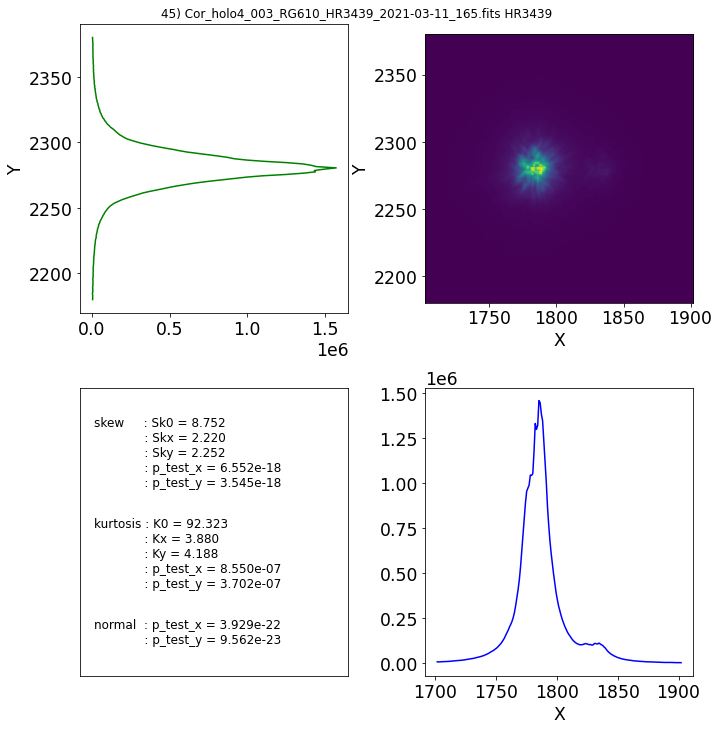

>>> FAILED : 45) Cor_holo4_003_RG610_HR3439_2021-03-11_165.fits HR3439
>>> FAILED : guess =  [1900, 2200]
46) Cor_holo4_003_RG610_HR3439_2021-03-11_166.fits HR3439


2021-04-24 20:58:39  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.269716024552759 but average of self.read_out_noise is 8.5.


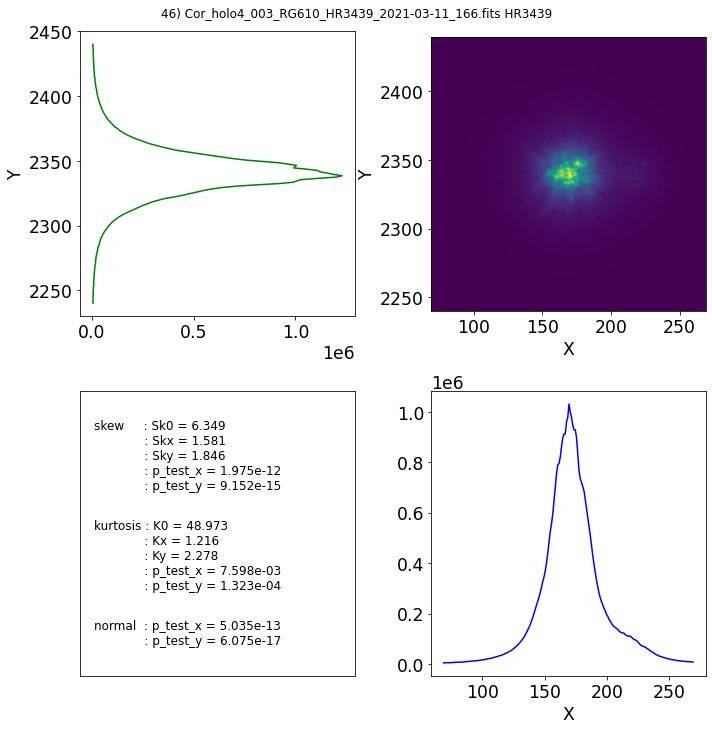

>>> FAILED : 46) Cor_holo4_003_RG610_HR3439_2021-03-11_166.fits HR3439
>>> FAILED : guess =  [200, 2300]
47) Cor_holo4_003_RG610_HD75519_2021-03-11_191.fits HD75519


2021-04-24 20:58:50  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.408695615217948 but average of self.read_out_noise is 8.5.


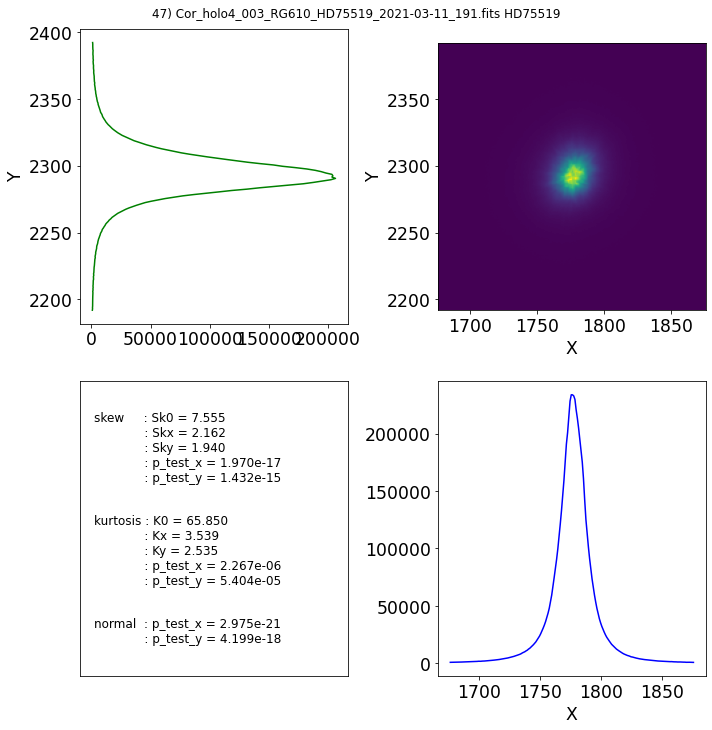

>>> FAILED : 47) Cor_holo4_003_RG610_HD75519_2021-03-11_191.fits HD75519
>>> FAILED : guess =  [1700, 2300]
48) Cor_holo4_003_RG610_HD75519_2021-03-11_192.fits HD75519


2021-04-24 20:59:01  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.407901568205844 but average of self.read_out_noise is 8.5.


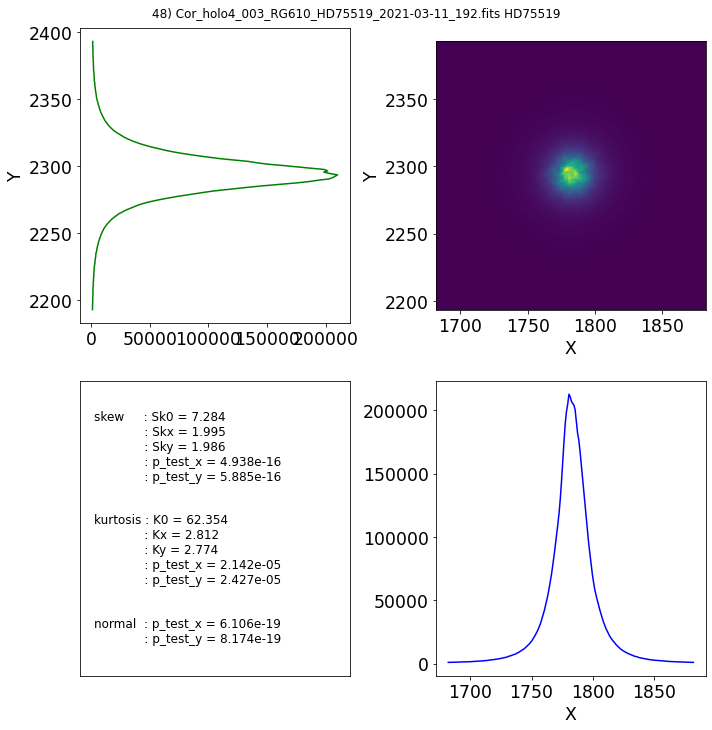

>>> FAILED : 48) Cor_holo4_003_RG610_HD75519_2021-03-11_192.fits HD75519
>>> FAILED : guess =  [1700, 2300]
49) Cor_holo4_003_RG610_HD75519_2021-03-11_193.fits HD75519


2021-04-24 20:59:11  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.405934420449931 but average of self.read_out_noise is 8.5.


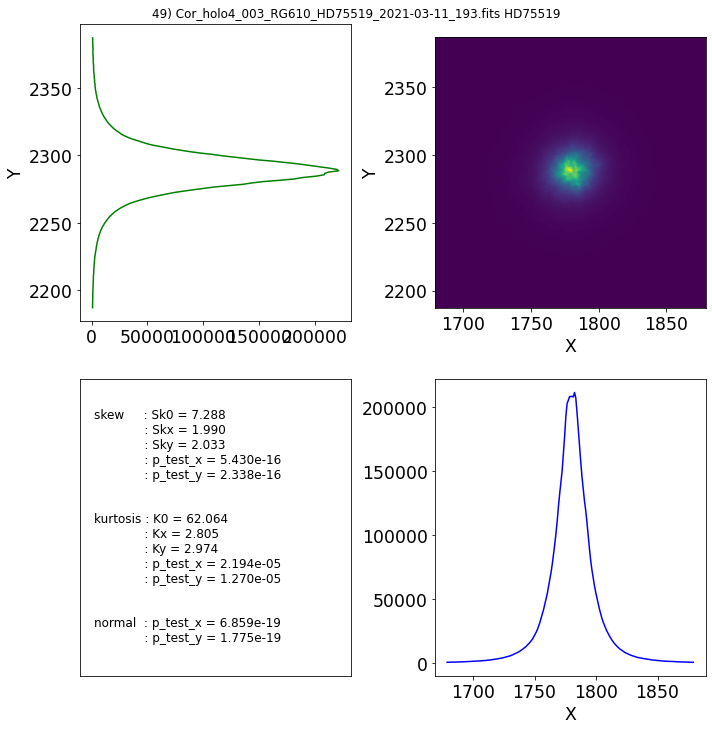

>>> FAILED : 49) Cor_holo4_003_RG610_HD75519_2021-03-11_193.fits HD75519
>>> FAILED : guess =  [1700, 2300]
50) Cor_holo4_003_RG610_HD75519_2021-03-11_284.fits HD75519


2021-04-24 20:59:30  Image      find_target_Moffat2D WARNING 
	X=53.50, Y=48.09 target position determination probably wrong: 5.7 pixels from profile detection (48.53, 50.86)


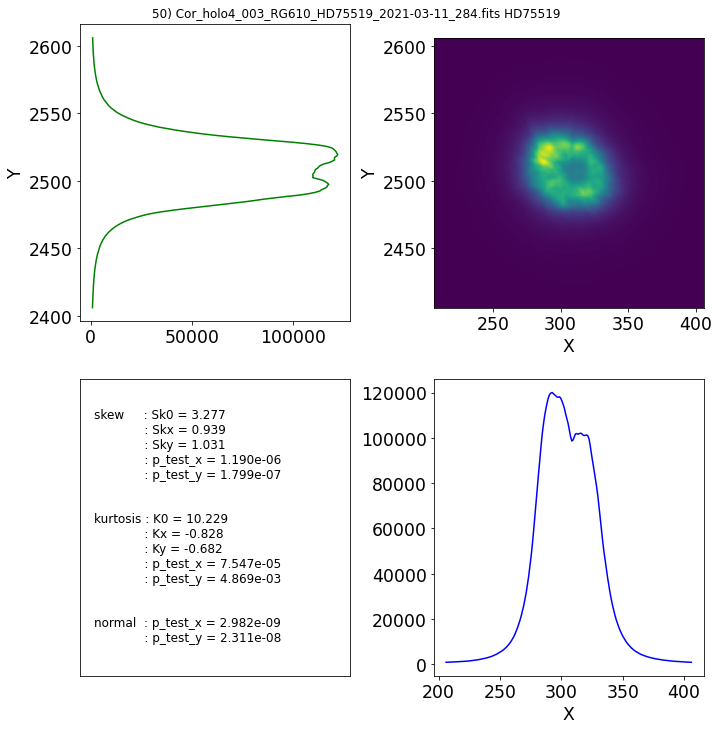

>>> FAILED : 50) Cor_holo4_003_RG610_HD75519_2021-03-11_284.fits HD75519
>>> FAILED : guess =  [300, 2500]
51) Cor_holo4_003_RG610_HD75519_2021-03-11_285.fits HD75519


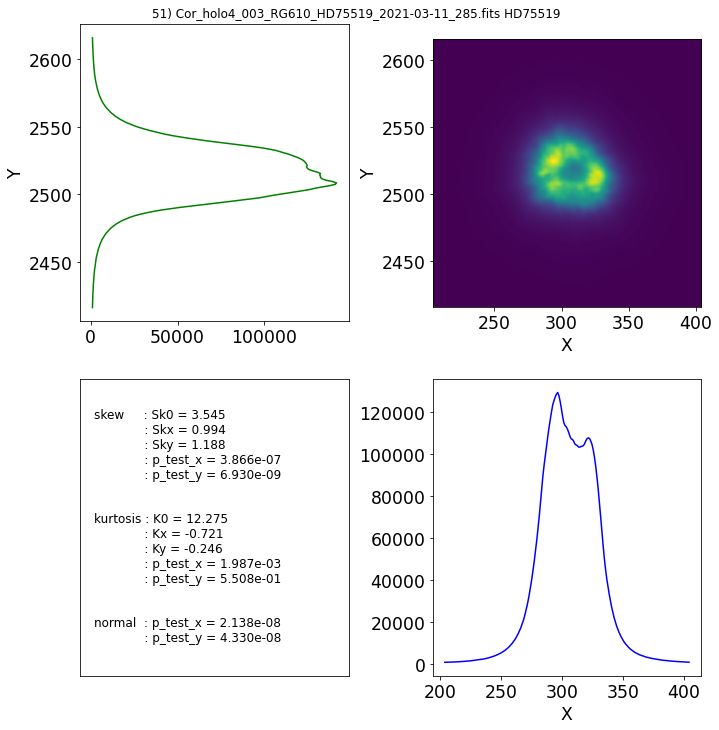

>>> FAILED : 51) Cor_holo4_003_RG610_HD75519_2021-03-11_285.fits HD75519
>>> FAILED : guess =  [300, 2500]
52) Cor_holo4_003_RG610_HD75519_2021-03-11_286.fits HD75519


2021-04-24 20:59:54  Image      find_target_Moffat2D WARNING 
	X=92.07, Y=113.17 target position determination probably wrong: 8.6 pixels from profile detection (100.11, 116.18)


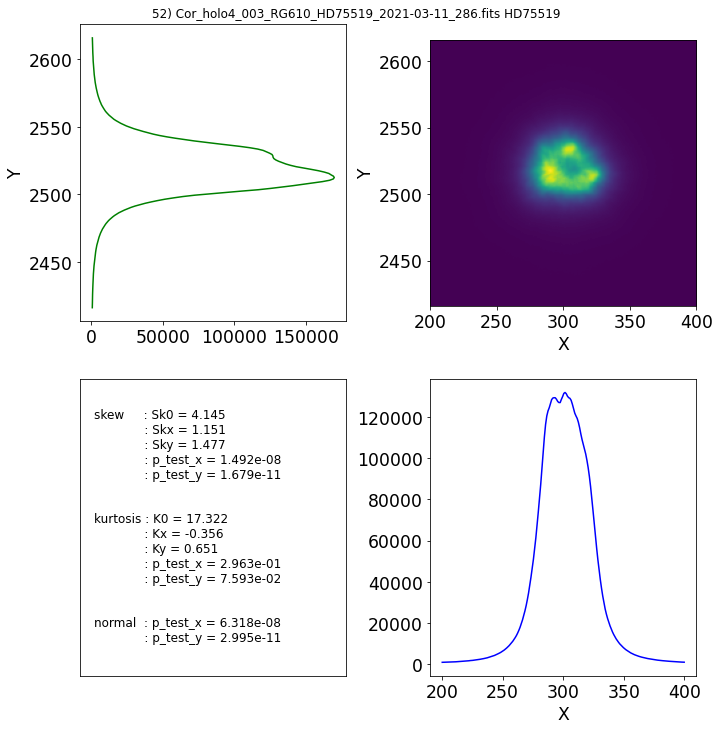

>>> FAILED : 52) Cor_holo4_003_RG610_HD75519_2021-03-11_286.fits HD75519
>>> FAILED : guess =  [300, 2500]
53) Cor_holo4_003_RG610_HD75519_2021-03-11_287.fits HD75519


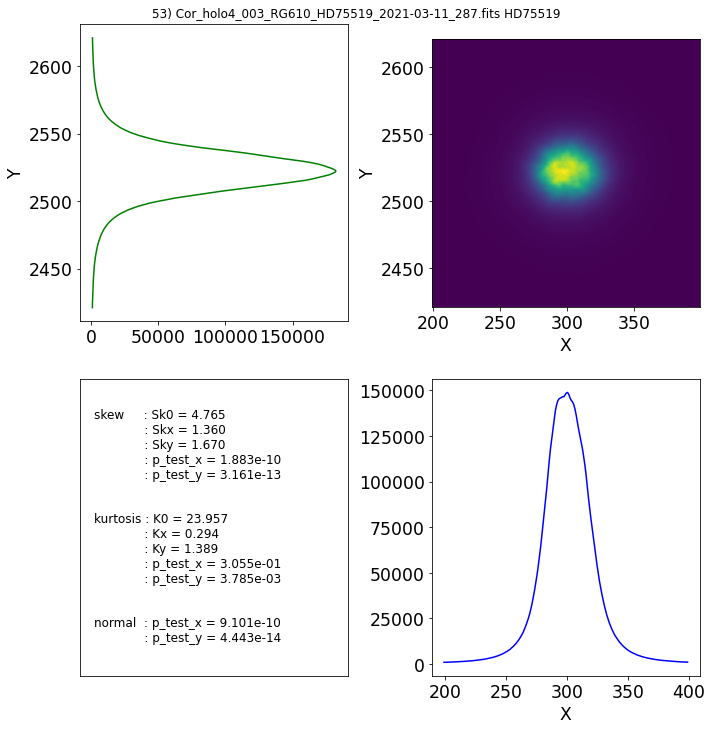

>>> FAILED : 53) Cor_holo4_003_RG610_HD75519_2021-03-11_287.fits HD75519
>>> FAILED : guess =  [300, 2500]
54) Cor_holo4_003_RG610_HD75519_2021-03-11_288.fits HD75519


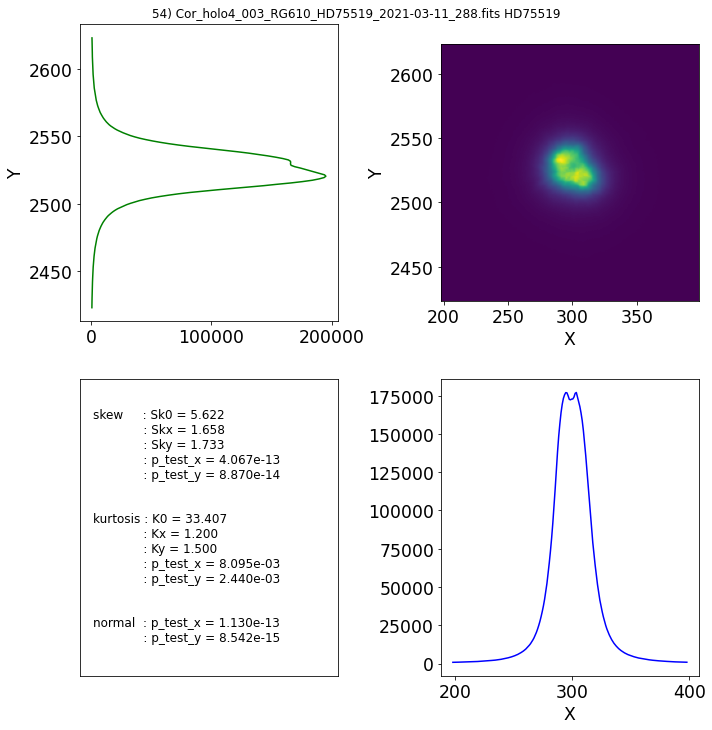

>>> FAILED : 54) Cor_holo4_003_RG610_HD75519_2021-03-11_288.fits HD75519
>>> FAILED : guess =  [300, 2500]
55) Cor_holo4_003_RG610_HD75519_2021-03-11_289.fits HD75519


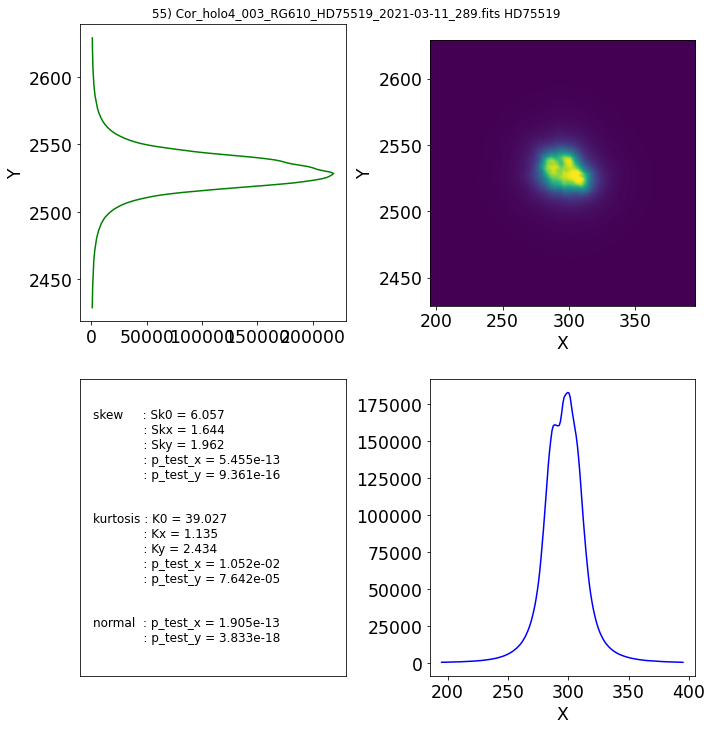

>>> FAILED : 55) Cor_holo4_003_RG610_HD75519_2021-03-11_289.fits HD75519
>>> FAILED : guess =  [300, 2500]
56) Cor_holo4_003_RG610_HD75519_2021-03-11_290.fits HD75519


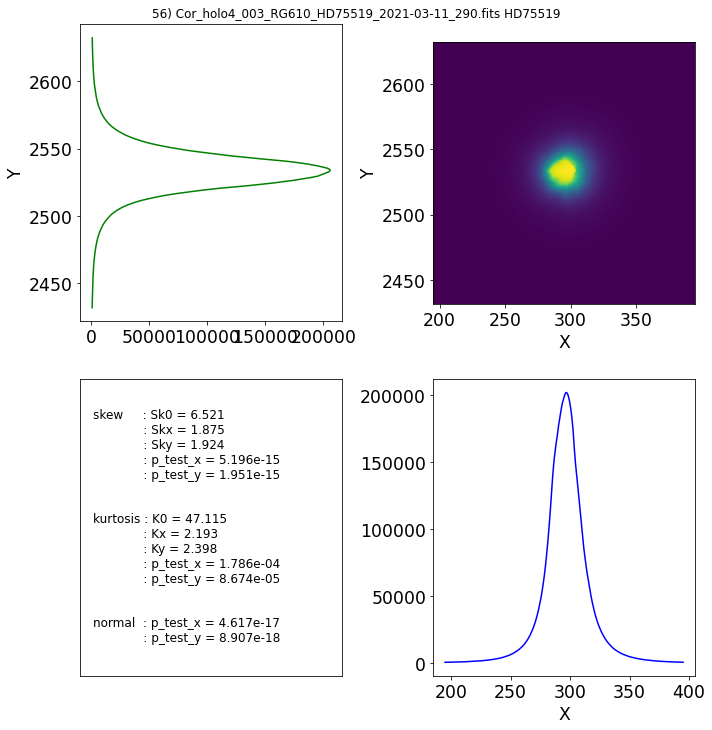

>>> FAILED : 56) Cor_holo4_003_RG610_HD75519_2021-03-11_290.fits HD75519
>>> FAILED : guess =  [300, 2500]
57) Cor_holo4_003_RG610_HD75519_2021-03-11_291.fits HD75519


In [ ]:

if True:


    idx=0
    infos={}
    
    
    for filename_image in df["file"]:
        
        try:
    
            fullfilename=os.path.join(dir_images,filename_image)
            X=df.iloc[idx]["Obj-posXpix"]
            Y=df.iloc[idx]["Obj-posYpix"]
            guess = [int(X),int(Y)]
            target = file_target(filename_image)[0]
    
            title=str(idx) + ") "+ filename_image + " " + target 
            print(title)
    

            image=Image(file_name=fullfilename, target_label=target, disperser_label=disperser_label, config=config)
            #image.plot_image(figsize=(12, 10),scale="log")
            parameters.VERBOSE = False
            parameters.DEBUG = False
            x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
    
            if x1>100:
                WID=100
            else:
                WID=50
    

            thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
            thumbnail_y=thumbnail.sum(axis=1)
            thumbnail_x=thumbnail.sum(axis=0)
            xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
            yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
            k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
            kx=kurtosis(thumbnail_x,bias=True,fisher=True)
            ky=kurtosis(thumbnail_y,bias=True,fisher=True)
            s0=skew(thumbnail,axis=None,bias=True)
            sx=skew(thumbnail_x,bias=True)
            sy=skew(thumbnail_y,bias=True)
            
            
        
            # statistical test
            kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
            skew_test_prob=skewtest(thumbnail,axis=None).pvalue
            normal_test_prob=normaltest(thumbnail,axis=None).pvalue
            
            kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
            skew_test_prob_x=skewtest(thumbnail_x).pvalue
            normal_test_prob_x=normaltest(thumbnail_x).pvalue       
            
            kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
            skew_test_prob_y=skewtest(thumbnail_y).pvalue
            normal_test_prob_y=normaltest(thumbnail_y).pvalue
        
        
            
            shape_str='\n'.join((
                r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
                r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))
    
            skew_str='\n'.join((
                r'skew     : Sk0 = {:3.3f}'.format(s0),
                r'             : Skx = {:3.3f}'.format(sx),
                r'             : Sky = {:3.3f}'.format(sy),
                r'             : p_test = {:3.3e}'.format(skew_test_prob)))
        
    
            kurt_str='\n'.join((
                r'kurtosis : K0 = {:3.3f}'.format(k0),
                r'             : Kx = {:3.3f}'.format(kx),
                r'             : Ky = {:3.3f}'.format(ky),
                r'             : p_test = {:3.3e}'.format(kurtosis_test_prob)))
        
            norm_str='p_normal_test = {:3.3e}'.format(normal_test_prob)
            
            
            
            skew_str='\n'.join((
                r'skew     : Sk0 = {:3.3f}'.format(s0),
                r'             : Skx = {:3.3f}'.format(sx),
                r'             : Sky = {:3.3f}'.format(sy),
                r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
                r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))
            
            
            kurt_str='\n'.join((
                r'kurtosis : K0 = {:3.3f}'.format(k0),
                r'             : Kx = {:3.3f}'.format(kx),
                r'             : Ky = {:3.3f}'.format(ky),
                r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
                r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))
            
        
            norm_str='\n'.join((
                r'normal  : p_test_x = {:3.3e}'.format(normal_test_prob_x),
                r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))
        
        
        
            #print("skew_str:",skew_str)
            #print("kurtosis_str:",kurt_str)
            #print("norm_str:",norm_str)
    
            props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)
    
            fig=plt.figure(figsize=(10,10))
            fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,bottom=0.15, top=0.9)

            ax=fig.add_subplot(222)
            ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
            ax.set_xlabel("X")
            ax.set_ylabel("Y")

            ax=fig.add_subplot(221)
            base = plt.gca().transData
            rot = transforms.Affine2D().rotate_deg(-90)
            #ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
            ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
            ax.set_ylabel("Y")

            ax=fig.add_subplot(224)
            ax.plot(xx,thumbnail_x,"b")
            ax.set_xlabel("X")
            plt.tight_layout()

            ax=fig.add_subplot(223)
            ax.set_xlim(0,10)
            ax.set_ylim(0,10)
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            #ax.text(0.05, 0.95, shape_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
            ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
            ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
            ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
            plt.suptitle(title,Y=1.01)
            plt.show()
        
        
            infos[filename_image1] = (s0,sx,sy,k0,kx,ky)
        
        
        except:
            msg=">>> FAILED : "+str(idx) + ") "+ filename_image + " " + target 
            print(msg)
            print(">>> FAILED : guess = ",guess)
    
        
        finally:
            idx+=1

        
        
 